## Actor Critic

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gym
%matplotlib inline

# These functions allow us to preprocess 
# original images from size of 210x160x3 
# to size of 84x84 (grayscale images).

import theano
from PIL import Image

def preprocess(image):
    def_h = 84
    def_w = 84
    img = 0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2]
    
    img = Image.fromarray(img).resize((def_h, def_w))
    
    img = np.expand_dims(img, axis=2)
    return img

def preprocess_tensor(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], tensor.shape[1], def_w, def_h, 1),dtype=theano.config.floatX)
    for i in xrange(tensor.shape[0]):
        for j in xrange(tensor.shape[1]):
            img = 0.299*tensor[i,j,:,:,0] + 0.587*tensor[i,j,:,:,1] + 0.114*tensor[i,j,:,:,2]
            tnsr[i,j,:,:,0] = Image.fromarray(img).resize((def_h, def_w))
    return tnsr

def preprocess_tensor4(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], def_w, def_h, 1),dtype=theano.config.floatX)
    for i in xrange(tensor.shape[0]):
        img = 0.299*tensor[i,:,:,0] + 0.587*tensor[i,:,:,1] + 0.114*tensor[i,:,:,2]
        tnsr[i,:,:,0] = Image.fromarray(img).resize((def_h, def_w))
    return tnsr

### Game Parameters

In [5]:
experiment_setup_name = "tutorial.gym.atari.MsPacman-v0.cnn"
GAME_TITLE = 'MsPacman-v0'
N_PARALLEL_GAMES = 16
replay_seq_len = 64

atari = gym.make(GAME_TITLE)
atari.reset()
n_actions = atari.action_space.n
observation_shape = (None,) + (84, 84, 1)
action_names = ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
print action_names

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [6]:
observation_shape

(1, 84, 84)

In [7]:
del atari

### Observations and Memory

In [10]:
import lasagne
import theano.tensor as T
from lasagne.layers import *
from agentnet.memory import WindowAugmentation

observation_layer = InputLayer((None,)+observation_shape,)

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])

observation_layer.output_shape, new_wnd.output_shape, prev_wnd.output_shape, wnd_reshape.shape

((None, 1, 84, 84),
 (None, 4, 1, 84, 84),
 (None, 4, 1, 84, 84),
 (-1, 4, 84, 84))

In [11]:
from lasagne.layers import DropoutLayer,DenseLayer, ExpressionLayer
from lasagne.nonlinearities import softmax, elu

nn = lasagne.layers.Conv2DLayer(wnd_reshape, num_filters=16, filter_size=(8, 8), stride=(4, 4), nonlinearity=elu)
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=32, filter_size=(4, 4), stride=(2, 2), nonlinearity=elu)
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DenseLayer(nn, num_units=256)
nn = lasagne.layers.BatchNormLayer(nn)

In [12]:
wnd_reshape.output_shape, nn.output_shape

((None, 4, 84, 84), (None, 256))

### Resolver

In [13]:
from agentnet.resolver import EpsilonGreedyResolve

logits_layer = DenseLayer(nn,n_actions,nonlinearity=None) 
policy_layer = lasagne.layers.NonlinearityLayer(logits_layer,softmax)

V_layer = DenseLayer(nn,1,nonlinearity=None)
action_layer = EpsilonGreedyResolver(policy_layer,name="resolver")

### Putting it together

In [15]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(logits_layer,V_layer),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)

weights = lasagne.layers.get_all_params([V_layer,policy_layer],trainable=True)
weights

[W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b]

### Environment, pool and all other stuff

In [17]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, N_PARALLEL_GAMES)

[2017-05-24 04:06:41,721] Making new env: MsPacman-v0
[2017-05-24 04:06:41,963] Making new env: MsPacman-v0
[2017-05-24 04:06:42,137] Making new env: MsPacman-v0
[2017-05-24 04:06:42,310] Making new env: MsPacman-v0
[2017-05-24 04:06:42,485] Making new env: MsPacman-v0
[2017-05-24 04:06:42,658] Making new env: MsPacman-v0
[2017-05-24 04:06:42,827] Making new env: MsPacman-v0
[2017-05-24 04:06:42,996] Making new env: MsPacman-v0
[2017-05-24 04:06:43,165] Making new env: MsPacman-v0
[2017-05-24 04:06:43,334] Making new env: MsPacman-v0
[2017-05-24 04:06:43,503] Making new env: MsPacman-v0
[2017-05-24 04:06:43,672] Making new env: MsPacman-v0
[2017-05-24 04:06:43,841] Making new env: MsPacman-v0
[2017-05-24 04:06:44,010] Making new env: MsPacman-v0
[2017-05-24 04:06:44,179] Making new env: MsPacman-v0
[2017-05-24 04:06:44,348] Making new env: MsPacman-v0


In [18]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

[['NOOP' 'UPRIGHT' 'NOOP' 'DOWNLEFT' 'DOWNLEFT']
 ['NOOP' 'DOWN' 'DOWN' 'DOWN' 'NOOP']
 ['RIGHT' 'DOWN' 'DOWN' 'UP' 'NOOP']]
CPU times: user 1.54 s, sys: 56 ms, total: 1.59 s
Wall time: 1.59 s


In [20]:
replay = pool.experience_replay

_,_,_,_,(logits_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=replay_seq_len,
    experience_replay=True,
    unroll_scan=False,
)
auto_updates = agent.get_automatic_updates()

import theano.tensor as T
logits_flat = logits_seq.reshape([-1,logits_seq.shape[-1]])
policy_seq = T.nnet.softmax(logits_flat).reshape(logits_seq.shape)
logpolicy_seq = T.nnet.logsoftmax(logits_flat).reshape(logits_seq.shape)
        

from agentnet.learning import a2c
elwise_actor_loss,elwise_critic_loss = a2c.get_elementwise_objective(policy=logpolicy_seq,
                                                                     treat_policy_as_logpolicy=True,
                                                                     state_values=V_seq[:,:,0],
                                                                     actions=replay.actions[0],
                                                                     rewards=replay.rewards,
                                                                     is_alive=replay.is_alive,
                                                                     gamma_or_gammas=0.99,
                                                                     n_steps=None,
                                                                     return_separate=True)
        
reg_logits = T.mean(logits_seq**2)
reg_entropy = T.mean(T.sum(policy_seq*logpolicy_seq,axis=-1))
loss = 0.1*elwise_actor_loss.mean() + 0.25*elwise_critic_loss.mean() + 1e-3*reg_entropy + 1e-3*reg_logits

In [21]:
grads = T.grad(loss,weights)
grads = lasagne.updates.total_norm_constraint(grads,10)

updates = lasagne.updates.adam(grads, weights,1e-4)


train_step = theano.function([],loss,updates=auto_updates+updates)
eval_step = theano.function([],
                            [elwise_actor_loss.mean(), elwise_critic_loss.mean()], 
                            updates=auto_updates)
import gc
gc.collect()

/home/vishimtsev/.local/lib/python2.7/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


3429

### Training

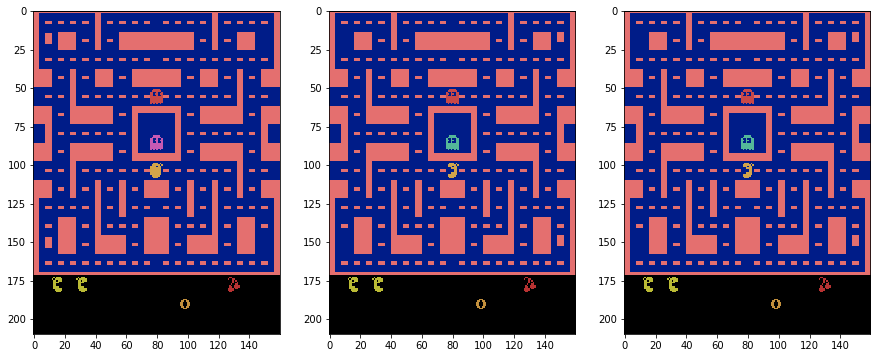

In [23]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.envs[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()

display_sessions()

In [66]:
import os
from agentnet.display import Metrics
score_log = Metrics()

epoch_counter = 1
alpha = 0.1
loss, prev_actor_loss, prev_critic_loss = 0,0,0
rewards = {}
reward, reward_per_tick = 0, 0

epoch 10,loss 591.98285 (A: 1.76496, C: 84.17718), epsilon 0.49552, reward 0.03564
epoch 20,loss 697.31427 (A: 5.51027, C: 1024.60230), epsilon 0.49109, reward 0.10173
epoch 30,loss 571.78093 (A: 6.05860, C: 983.70089), epsilon 0.48670, reward 0.11374
epoch 40,loss 396.32310 (A: 6.81965, C: 955.41400), epsilon 0.48236, reward 0.13344
epoch 50,loss 331.50208 (A: 7.42574, C: 928.32364), epsilon 0.47805, reward 0.15021
epoch 3400,loss 419.42951 (A: 3.69028, C: 774.44127), epsilon 0.06502, reward 0.50096
Learning curves:


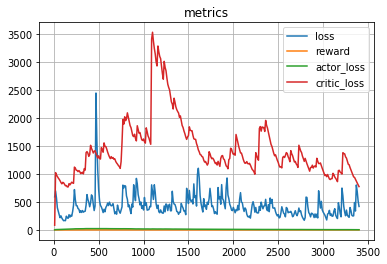

Random session examples.


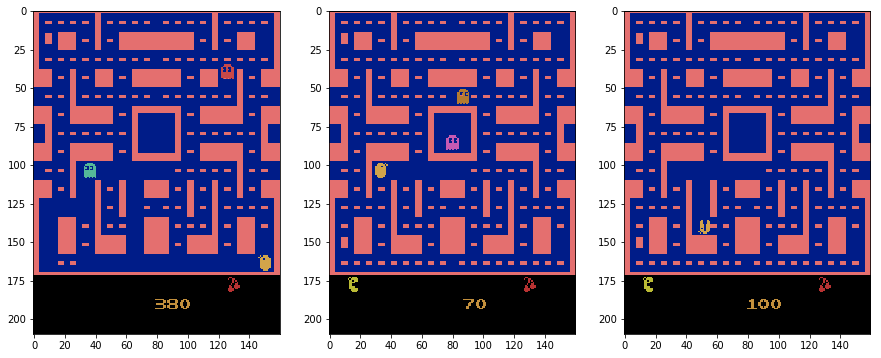

epoch 3410,loss 348.45132 (A: 4.09215, C: 847.55401), epsilon 0.06487, reward 0.52181
epoch 3420,loss 340.10088 (A: 4.14179, C: 831.81358), epsilon 0.06472, reward 0.52892
epoch 3430,loss 262.23260 (A: 4.03986, C: 814.29371), epsilon 0.06457, reward 0.53324
epoch 3440,loss 211.79540 (A: 3.86344, C: 780.55983), epsilon 0.06443, reward 0.52025
epoch 3450,loss 219.85941 (A: 3.77041, C: 756.76326), epsilon 0.06429, reward 0.51963
epoch 3460,loss 199.95703 (A: 3.60020, C: 725.80559), epsilon 0.06414, reward 0.51806
epoch 3470,loss 1459.54736 (A: 3.49203, C: 701.37800), epsilon 0.06400, reward 0.52145
epoch 3480,loss 1099.94420 (A: 3.28597, C: 677.30038), epsilon 0.06386, reward 0.50856
epoch 3490,loss 799.64295 (A: 3.46788, C: 953.26334), epsilon 0.06373, reward 0.53148
epoch 3500,loss 604.11755 (A: 3.37244, C: 918.31137), epsilon 0.06359, reward 0.52834
Learning curves:


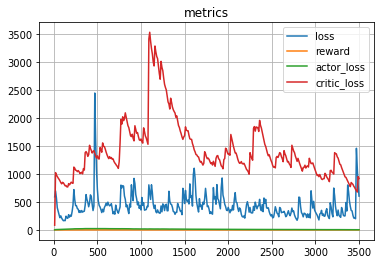

Random session examples.


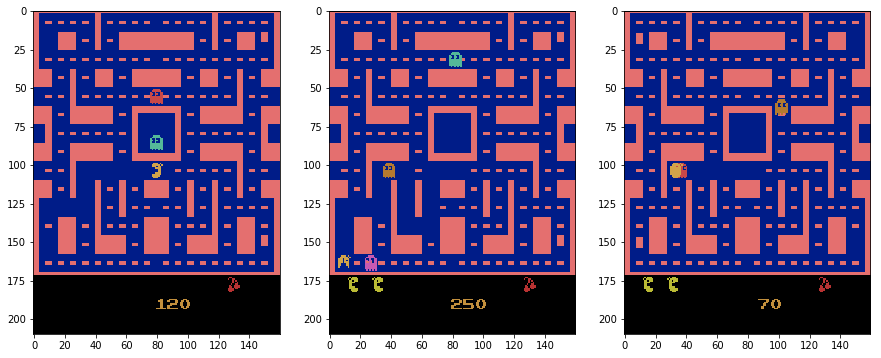

epoch 3510,loss 432.02241 (A: 3.74385, C: 952.55584), epsilon 0.06345, reward 0.55270
epoch 3520,loss 321.04552 (A: 3.71571, C: 946.99564), epsilon 0.06332, reward 0.55583
epoch 3530,loss 271.27688 (A: 3.63145, C: 907.99418), epsilon 0.06319, reward 0.54952
epoch 3540,loss 226.69104 (A: 3.82395, C: 891.75058), epsilon 0.06306, reward 0.55525
epoch 3550,loss 299.78258 (A: 3.68200, C: 856.74613), epsilon 0.06293, reward 0.54165
epoch 3560,loss 249.78809 (A: 3.62777, C: 836.88780), epsilon 0.06280, reward 0.53214
epoch 3570,loss 249.60188 (A: 3.60321, C: 816.49752), epsilon 0.06267, reward 0.53337
epoch 3580,loss 480.57791 (A: 3.55348, C: 788.83739), epsilon 0.06254, reward 0.53063
epoch 3590,loss 813.18758 (A: 3.83398, C: 1007.24337), epsilon 0.06242, reward 0.55243
epoch 3600,loss 543.17461 (A: 3.66500, C: 963.62172), epsilon 0.06230, reward 0.53897
Learning curves:


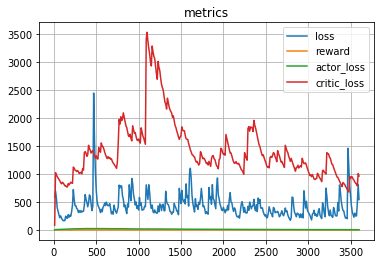

Random session examples.


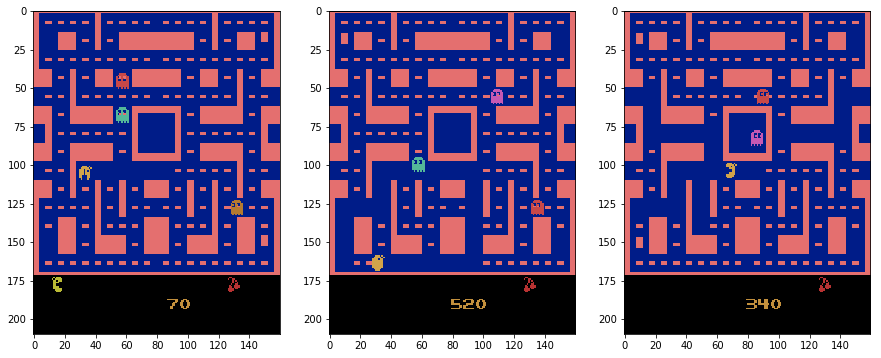

epoch 3610,loss 382.45968 (A: 3.57276, C: 927.31670), epsilon 0.06217, reward 0.54230
epoch 3620,loss 303.21153 (A: 3.47632, C: 895.34858), epsilon 0.06205, reward 0.53764
epoch 3630,loss 246.76517 (A: 3.38737, C: 900.72304), epsilon 0.06193, reward 0.53420
epoch 3640,loss 298.86887 (A: 3.29834, C: 863.74458), epsilon 0.06181, reward 0.52556
epoch 3650,loss 216.87952 (A: 3.18803, C: 827.58105), epsilon 0.06170, reward 0.51734
epoch 3660,loss 204.70650 (A: 3.22020, C: 811.60848), epsilon 0.06158, reward 0.51833
epoch 3670,loss 161.74552 (A: 3.12817, C: 782.08760), epsilon 0.06146, reward 0.50755
epoch 3680,loss 347.80536 (A: 3.09919, C: 752.54634), epsilon 0.06135, reward 0.49926
epoch 3690,loss 268.79370 (A: 2.87376, C: 723.49454), epsilon 0.06124, reward 0.48211
epoch 3700,loss 191.88466 (A: 2.96546, C: 707.26066), epsilon 0.06113, reward 0.48779
Learning curves:


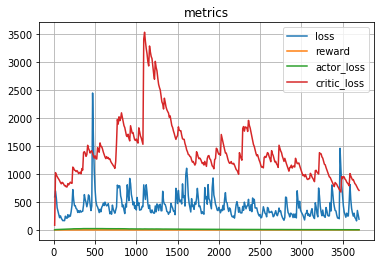

Random session examples.


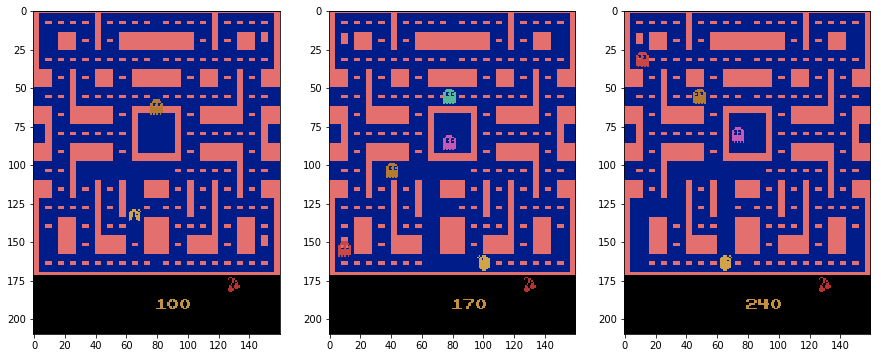

epoch 3710,loss 152.38783 (A: 2.93245, C: 685.63937), epsilon 0.06101, reward 0.48586
epoch 3720,loss 163.59831 (A: 2.91949, C: 660.34451), epsilon 0.06091, reward 0.48745
epoch 3730,loss 510.44575 (A: 3.44120, C: 1036.97523), epsilon 0.06080, reward 0.51777
epoch 3740,loss 345.08282 (A: 3.46970, C: 1002.80273), epsilon 0.06069, reward 0.52215
epoch 3750,loss 246.01699 (A: 3.44216, C: 979.53633), epsilon 0.06058, reward 0.52241
epoch 3760,loss 335.11420 (A: 3.32419, C: 944.54381), epsilon 0.06048, reward 0.51680
epoch 3770,loss 281.85186 (A: 3.29883, C: 948.53347), epsilon 0.06037, reward 0.52611
epoch 3780,loss 214.80320 (A: 3.26601, C: 910.10921), epsilon 0.06027, reward 0.52373
epoch 3790,loss 236.52153 (A: 3.20812, C: 873.15179), epsilon 0.06017, reward 0.51757
epoch 3800,loss 191.51320 (A: 3.06437, C: 849.54235), epsilon 0.06007, reward 0.51171
Learning curves:


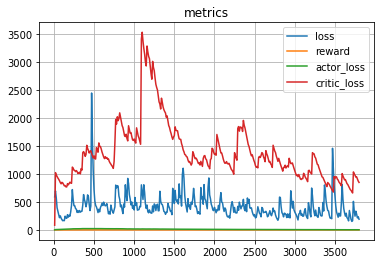

Random session examples.


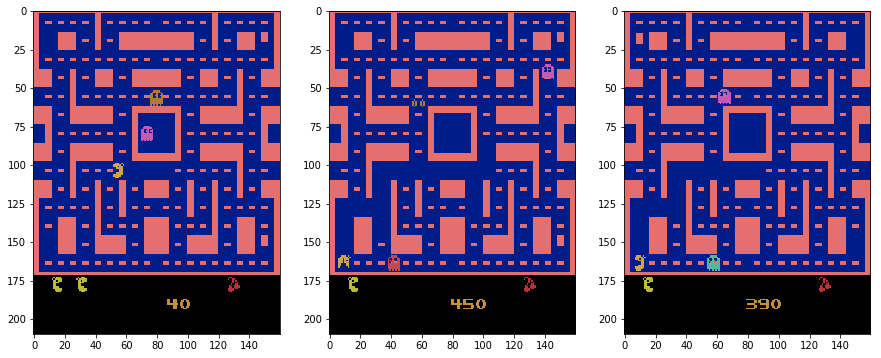

epoch 3810,loss 135.80469 (A: 3.13438, C: 829.08094), epsilon 0.05997, reward 0.51835
epoch 4160,loss 157.55651 (A: 2.63007, C: 537.78309), epsilon 0.05702, reward 0.48971
epoch 4170,loss 154.59709 (A: 2.61202, C: 528.08368), epsilon 0.05695, reward 0.49062
epoch 4180,loss 283.91048 (A: 2.94005, C: 906.26771), epsilon 0.05688, reward 0.51833
epoch 4190,loss 367.82467 (A: 2.79496, C: 868.07989), epsilon 0.05682, reward 0.50560
epoch 4200,loss 356.79862 (A: 2.70604, C: 834.52297), epsilon 0.05675, reward 0.50473
Learning curves:


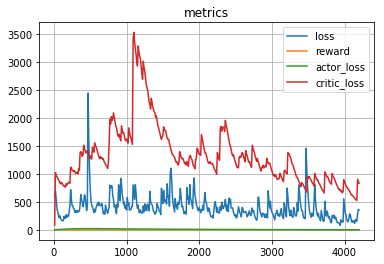

Random session examples.


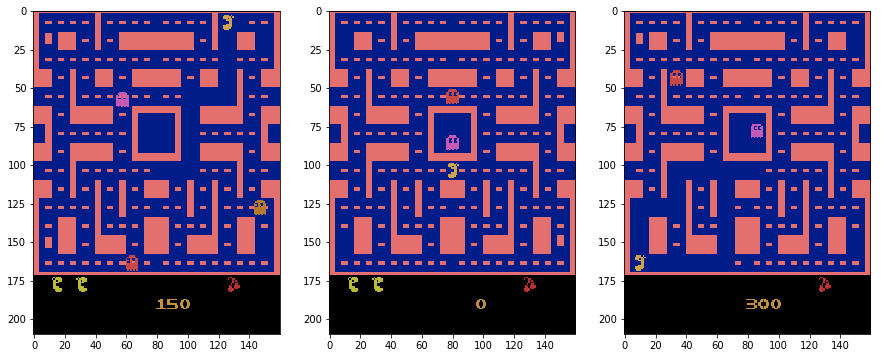

epoch 4210,loss 287.44659 (A: 2.66696, C: 803.23528), epsilon 0.05668, reward 0.50489
epoch 4220,loss 252.30616 (A: 2.69726, C: 824.85452), epsilon 0.05661, reward 0.52456
epoch 4230,loss 266.84641 (A: 2.56066, C: 796.94331), epsilon 0.05655, reward 0.51543
epoch 4240,loss 195.49688 (A: 2.52484, C: 766.86153), epsilon 0.05648, reward 0.50626
epoch 4250,loss 156.24970 (A: 2.50120, C: 746.93997), epsilon 0.05642, reward 0.50731
epoch 4260,loss 306.80772 (A: 2.59221, C: 760.93054), epsilon 0.05636, reward 0.51368
epoch 4280,loss 187.22528 (A: 2.60548, C: 720.52501), epsilon 0.05623, reward 0.51572
epoch 4290,loss 186.20142 (A: 2.61271, C: 705.60961), epsilon 0.05617, reward 0.51679
epoch 4300,loss 175.48883 (A: 2.71248, C: 686.39927), epsilon 0.05611, reward 0.51927
Learning curves:


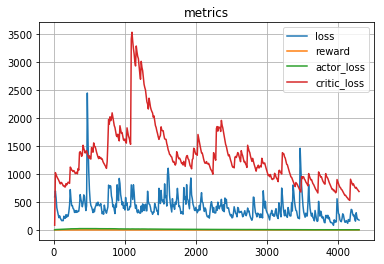

Random session examples.


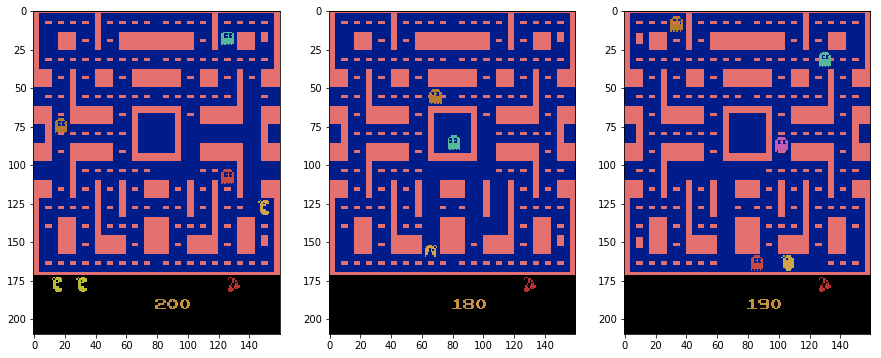

epoch 4310,loss 166.45457 (A: 2.80474, C: 669.67267), epsilon 0.05605, reward 0.52505
epoch 4320,loss 138.26816 (A: 2.74693, C: 652.93634), epsilon 0.05598, reward 0.52223
epoch 4330,loss 194.27754 (A: 2.80965, C: 644.54951), epsilon 0.05593, reward 0.53177
epoch 4340,loss 186.04882 (A: 3.11885, C: 681.16902), epsilon 0.05587, reward 0.53838
epoch 4350,loss 247.23331 (A: 3.23328, C: 671.60017), epsilon 0.05581, reward 0.54906
epoch 4360,loss 208.27188 (A: 3.43646, C: 679.80194), epsilon 0.05575, reward 0.56360
epoch 4370,loss 231.64328 (A: 3.60036, C: 875.33667), epsilon 0.05569, reward 0.58766
epoch 4380,loss 209.27989 (A: 3.77079, C: 907.02592), epsilon 0.05564, reward 0.59881
epoch 4870,loss 296.41710 (A: 3.42343, C: 894.79953), epsilon 0.05345, reward 0.70395
epoch 5750,loss 211.45946 (A: 2.83248, C: 1439.84799), epsilon 0.05143, reward 0.73508
epoch 5760,loss 206.31681 (A: 2.86567, C: 1382.98815), epsilon 0.05142, reward 0.73934
epoch 5770,loss 691.94537 (A: 2.76205, C: 1351.22848

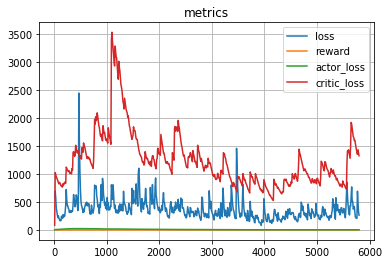

Random session examples.


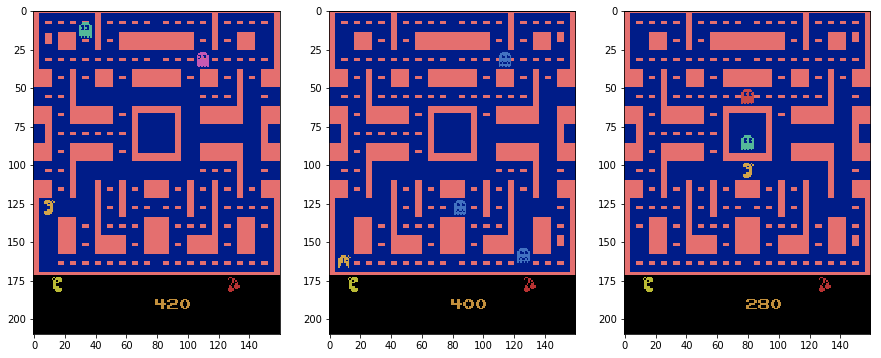

epoch 5810,loss 397.60912 (A: 2.95254, C: 1345.01271), epsilon 0.05135, reward 0.76851
epoch 5820,loss 322.73760 (A: 2.97150, C: 1299.64403), epsilon 0.05134, reward 0.76427
epoch 5830,loss 278.15250 (A: 2.90122, C: 1259.87793), epsilon 0.05132, reward 0.75926
epoch 5840,loss 230.04197 (A: 2.69908, C: 1229.67727), epsilon 0.05131, reward 0.74962
epoch 5850,loss 195.76000 (A: 2.60955, C: 1206.16044), epsilon 0.05130, reward 0.74876
epoch 5860,loss 214.98512 (A: 2.94647, C: 1228.99515), epsilon 0.05128, reward 0.76991
epoch 5870,loss 219.31555 (A: 2.74276, C: 1179.62102), epsilon 0.05127, reward 0.74753
epoch 5880,loss 175.88926 (A: 2.72067, C: 1147.88343), epsilon 0.05126, reward 0.75019
epoch 5890,loss 190.66704 (A: 2.79392, C: 1243.83811), epsilon 0.05125, reward 0.75907
epoch 5900,loss 149.91386 (A: 2.92777, C: 1215.72090), epsilon 0.05123, reward 0.76408
Learning curves:


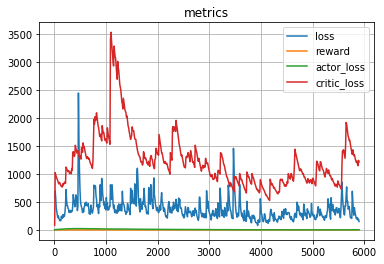

Random session examples.


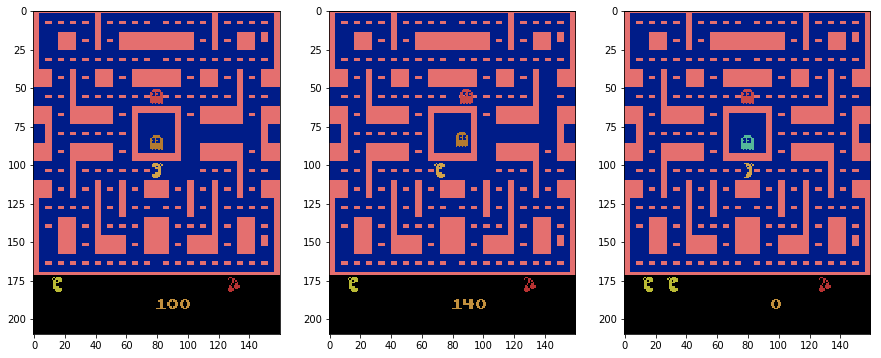

epoch 5910,loss 220.29498 (A: 2.93133, C: 1175.41837), epsilon 0.05122, reward 0.75615
epoch 5920,loss 248.33592 (A: 3.02596, C: 1404.49152), epsilon 0.05121, reward 0.77450
epoch 5930,loss 206.90129 (A: 3.05923, C: 1353.20802), epsilon 0.05120, reward 0.76507
epoch 5940,loss 566.08322 (A: 2.81076, C: 1325.15816), epsilon 0.05118, reward 0.75123
epoch 5950,loss 604.72525 (A: 2.63222, C: 1274.09878), epsilon 0.05117, reward 0.73955
epoch 5960,loss 420.09215 (A: 2.48932, C: 1223.41387), epsilon 0.05116, reward 0.73236
epoch 5970,loss 335.99339 (A: 2.08963, C: 1187.62839), epsilon 0.05115, reward 0.71283
epoch 5980,loss 250.75946 (A: 2.06977, C: 1149.19896), epsilon 0.05114, reward 0.71430
epoch 5990,loss 211.01891 (A: 2.08026, C: 1137.78558), epsilon 0.05113, reward 0.70837
epoch 6000,loss 191.63990 (A: 1.95284, C: 1095.30640), epsilon 0.05112, reward 0.69687
Learning curves:


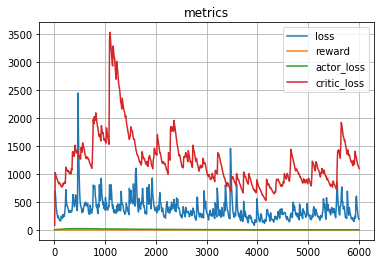

Random session examples.


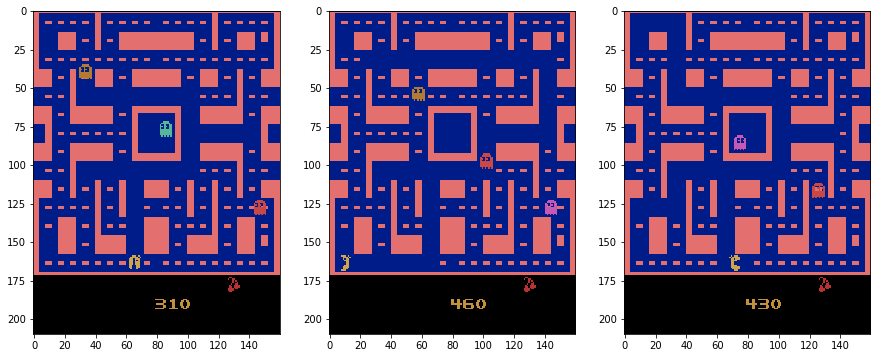

[2017-05-24 15:45:48,711] Making new env: MsPacman-v0
[2017-05-24 15:45:48,874] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 15:45:48,883] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.6.10942.video000000.mp4
[2017-05-24 15:45:50,555] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.6.10942.video000001.mp4


Episode finished after 481 timesteps with reward=70.0
Episode finished after 1345 timesteps with reward=230.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 574 timesteps with reward=110.0
Episode finished after 510 timesteps with reward=110.0
Episode finished after 950 timesteps with reward=780.0
Episode finished after 435 timesteps with reward=60.0


[2017-05-24 15:46:03,673] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.6.10942.video000008.mp4


Episode finished after 430 timesteps with reward=60.0
Episode finished after 446 timesteps with reward=60.0
Episode finished after 688 timesteps with reward=180.0
Episode finished after 933 timesteps with reward=180.0
Episode finished after 421 timesteps with reward=110.0
Episode finished after 458 timesteps with reward=110.0
Episode finished after 640 timesteps with reward=60.0
Episode finished after 594 timesteps with reward=110.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 701 timesteps with reward=180.0
Episode finished after 540 timesteps with reward=120.0


[2017-05-24 15:46:22,847] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/a2c_videos')


Episode finished after 703 timesteps with reward=380.0
Mean 154.5, Var 26524.75
epoch 6010,loss 232.36390 (A: 1.83931, C: 1183.76623), epsilon 0.05110, reward 0.71135
epoch 6020,loss 179.13046 (A: 1.75261, C: 1168.22571), epsilon 0.05109, reward 0.70703
epoch 6030,loss 159.92511 (A: 1.68352, C: 1128.16449), epsilon 0.05108, reward 0.69902
epoch 6040,loss 245.01242 (A: 1.77690, C: 1393.35607), epsilon 0.05107, reward 0.71534
epoch 6050,loss 339.94357 (A: 1.70681, C: 1336.29540), epsilon 0.05106, reward 0.70985
epoch 6060,loss 278.95253 (A: 1.77829, C: 1330.96323), epsilon 0.05105, reward 0.71537
epoch 6260,loss 369.23192 (A: 0.66308, C: 830.69350), epsilon 0.05086, reward 0.57915
epoch 6270,loss 604.50303 (A: 0.79098, C: 863.14414), epsilon 0.05085, reward 0.59072
epoch 6280,loss 424.04700 (A: 0.80023, C: 844.86975), epsilon 0.05084, reward 0.59439
epoch 6290,loss 481.38381 (A: 1.59566, C: 1207.04298), epsilon 0.05083, reward 0.61496
epoch 6300,loss 707.95280 (A: 1.74015, C: 1168.08614)

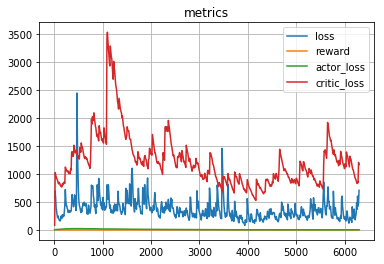

Random session examples.


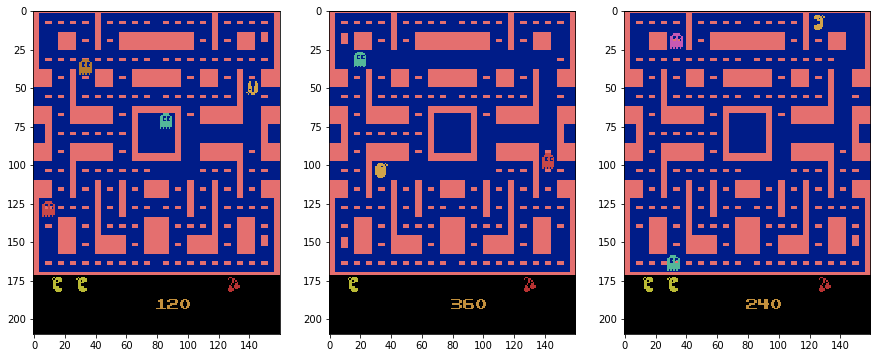

epoch 6310,loss 495.70719 (A: 1.65710, C: 1183.43514), epsilon 0.05082, reward 0.61545
epoch 6990,loss 417.65219 (A: 2.68045, C: 1665.72035), epsilon 0.05041, reward 0.77948
epoch 7000,loss 443.98338 (A: 2.77966, C: 1652.45548), epsilon 0.05041, reward 0.77908
Learning curves:


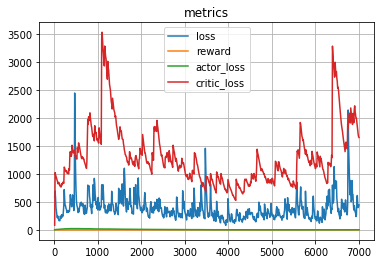

Random session examples.


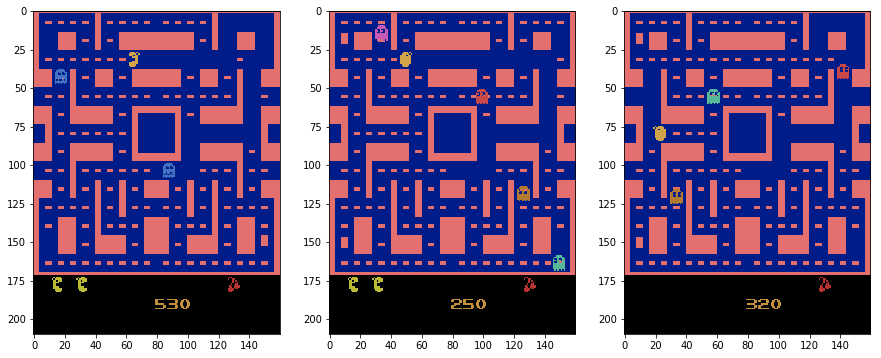

[2017-05-24 17:34:20,749] Making new env: MsPacman-v0
[2017-05-24 17:34:20,912] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 17:34:20,922] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.7.10942.video000000.mp4
[2017-05-24 17:34:22,533] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.7.10942.video000001.mp4


Episode finished after 476 timesteps with reward=90.0
Episode finished after 779 timesteps with reward=230.0
Episode finished after 533 timesteps with reward=110.0
Episode finished after 520 timesteps with reward=110.0
Episode finished after 621 timesteps with reward=180.0
Episode finished after 526 timesteps with reward=110.0
Episode finished after 810 timesteps with reward=380.0


[2017-05-24 17:34:33,956] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.7.10942.video000008.mp4


Episode finished after 432 timesteps with reward=60.0
Episode finished after 581 timesteps with reward=80.0
Episode finished after 655 timesteps with reward=150.0
Episode finished after 495 timesteps with reward=110.0
Episode finished after 562 timesteps with reward=140.0
Episode finished after 723 timesteps with reward=190.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 483 timesteps with reward=170.0
Episode finished after 783 timesteps with reward=180.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 556 timesteps with reward=170.0


[2017-05-24 17:34:51,467] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/a2c_videos')


Episode finished after 463 timesteps with reward=110.0
Mean 137.5, Var 5468.75
epoch 7010,loss 364.79702 (A: 2.75934, C: 1668.50184), epsilon 0.05041, reward 0.77821
epoch 7020,loss 404.78235 (A: 2.64075, C: 1607.66517), epsilon 0.05040, reward 0.77446
epoch 7030,loss 434.86011 (A: 2.47451, C: 1543.69504), epsilon 0.05040, reward 0.75624
epoch 7040,loss 342.29285 (A: 2.21341, C: 1543.58718), epsilon 0.05039, reward 0.74968
epoch 7050,loss 364.25459 (A: 2.22369, C: 1625.15148), epsilon 0.05039, reward 0.76102
epoch 7060,loss 308.63481 (A: 1.89621, C: 1577.64790), epsilon 0.05039, reward 0.75813
epoch 7070,loss 234.86618 (A: 1.71324, C: 1512.75504), epsilon 0.05038, reward 0.73780
epoch 7080,loss 770.90824 (A: 2.41213, C: 2937.37647), epsilon 0.05038, reward 0.80638
epoch 7090,loss 547.64697 (A: 2.30512, C: 2806.53244), epsilon 0.05038, reward 0.79096
epoch 7100,loss 378.41049 (A: 2.23540, C: 2683.53152), epsilon 0.05037, reward 0.78706
Learning curves:


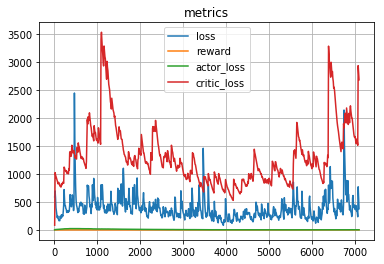

Random session examples.


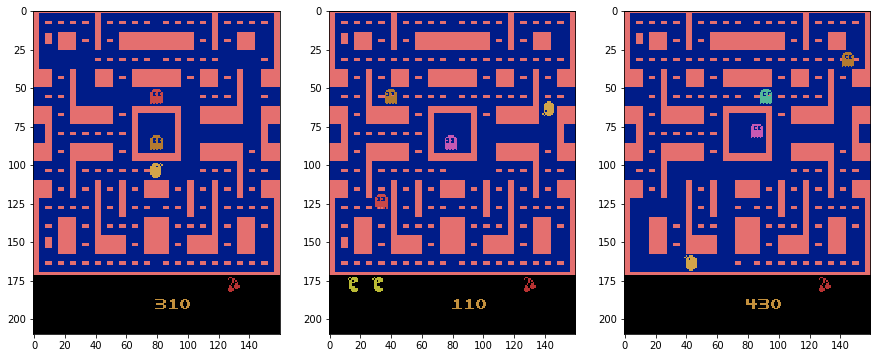

epoch 7110,loss 483.69627 (A: 2.41577, C: 2602.49018), epsilon 0.05037, reward 0.79898
epoch 7120,loss 837.45136 (A: 2.85135, C: 3029.17129), epsilon 0.05036, reward 0.83032
epoch 7130,loss 571.30500 (A: 2.78230, C: 2905.02066), epsilon 0.05036, reward 0.82396
epoch 7140,loss 757.50058 (A: 2.65912, C: 2949.96787), epsilon 0.05036, reward 0.82329
epoch 7150,loss 539.32124 (A: 2.60931, C: 2821.78884), epsilon 0.05035, reward 0.81386
epoch 7160,loss 504.85603 (A: 2.50652, C: 2699.89248), epsilon 0.05035, reward 0.80393
epoch 7170,loss 373.81549 (A: 2.63960, C: 2623.90432), epsilon 0.05035, reward 0.80768
epoch 7180,loss 313.08149 (A: 2.60583, C: 2518.20104), epsilon 0.05034, reward 0.80391
epoch 7190,loss 528.46656 (A: 2.55459, C: 2459.12938), epsilon 0.05034, reward 0.79204
epoch 7200,loss 380.20485 (A: 2.48784, C: 2360.58306), epsilon 0.05034, reward 0.78222
Learning curves:


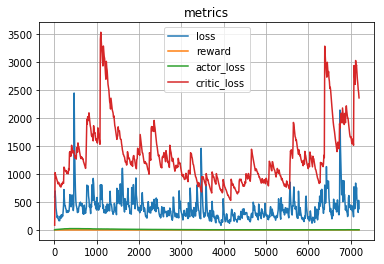

Random session examples.


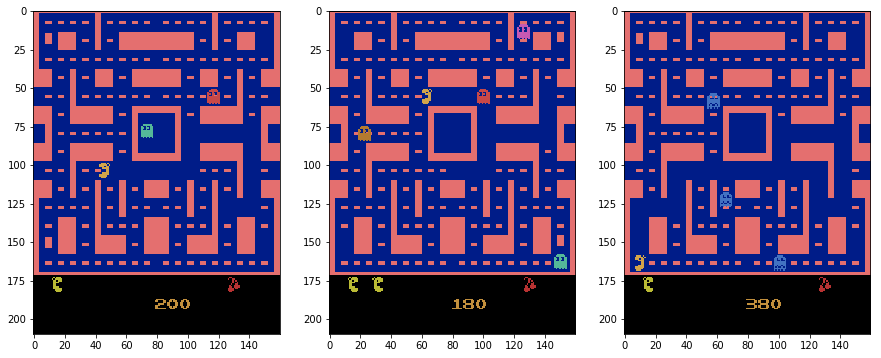

epoch 7210,loss 352.07975 (A: 2.41230, C: 2261.59020), epsilon 0.05033, reward 0.77485
epoch 7220,loss 355.72829 (A: 2.27748, C: 2166.55036), epsilon 0.05033, reward 0.76492
epoch 7230,loss 444.40905 (A: 2.19928, C: 2076.53092), epsilon 0.05033, reward 0.75938
epoch 7240,loss 329.39999 (A: 2.29684, C: 1995.72097), epsilon 0.05032, reward 0.76878
epoch 7250,loss 285.35533 (A: 2.14690, C: 1909.12031), epsilon 0.05032, reward 0.75817
epoch 7260,loss 242.71263 (A: 1.95879, C: 1855.15303), epsilon 0.05032, reward 0.76226
epoch 7270,loss 321.02863 (A: 1.91855, C: 1816.49454), epsilon 0.05031, reward 0.76174
epoch 7280,loss 512.97576 (A: 2.19539, C: 1808.02019), epsilon 0.05031, reward 0.76662
epoch 7290,loss 594.61752 (A: 2.52444, C: 2134.92416), epsilon 0.05031, reward 0.76979
epoch 7300,loss 515.62022 (A: 2.45878, C: 2055.99811), epsilon 0.05030, reward 0.76695
Learning curves:


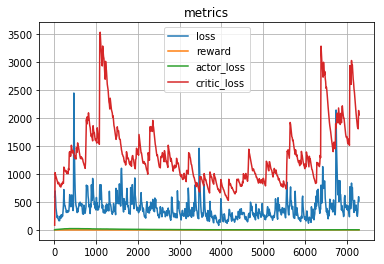

Random session examples.


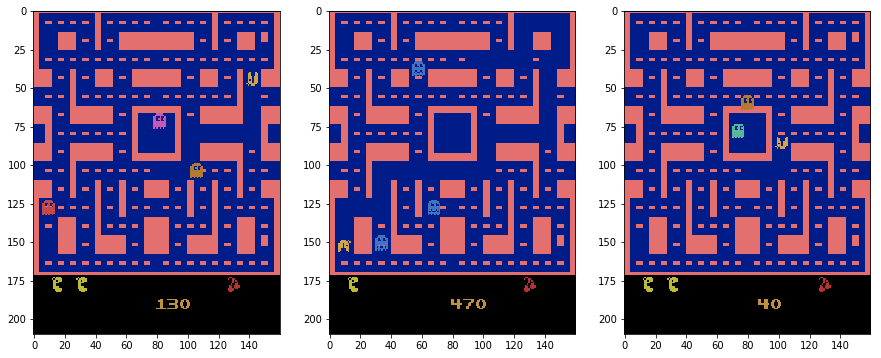

epoch 7310,loss 422.09017 (A: 2.27156, C: 1971.69756), epsilon 0.05030, reward 0.74472
epoch 7320,loss 594.00104 (A: 2.51108, C: 2892.81483), epsilon 0.05030, reward 0.79488
epoch 7330,loss 437.24200 (A: 2.48896, C: 2828.16023), epsilon 0.05030, reward 0.79469
epoch 7340,loss 454.73721 (A: 2.26377, C: 2702.90647), epsilon 0.05029, reward 0.78034
epoch 7350,loss 663.68385 (A: 2.01428, C: 2580.29769), epsilon 0.05029, reward 0.77062
epoch 7360,loss 519.61143 (A: 1.64474, C: 2470.93085), epsilon 0.05029, reward 0.74381
epoch 7370,loss 689.07093 (A: 1.73294, C: 2409.89824), epsilon 0.05028, reward 0.74227
epoch 7380,loss 598.68445 (A: 1.34185, C: 2307.47397), epsilon 0.05028, reward 0.71931
epoch 7390,loss 400.43820 (A: 0.90294, C: 2211.16715), epsilon 0.05028, reward 0.69604
epoch 7400,loss 707.82232 (A: 1.18492, C: 2190.33708), epsilon 0.05028, reward 0.70519
Learning curves:


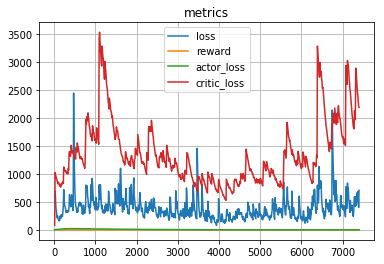

Random session examples.


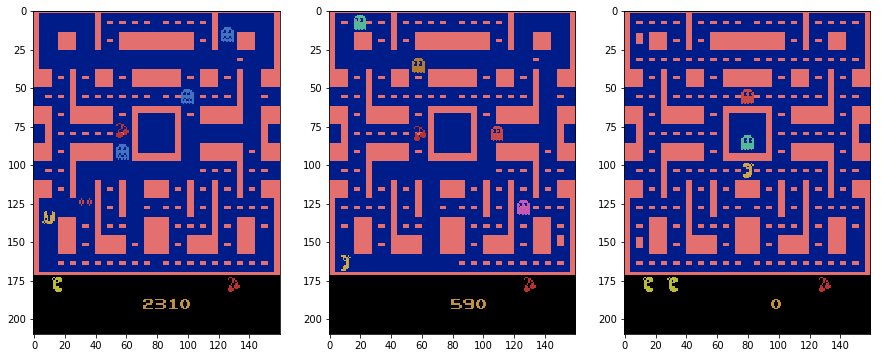

epoch 7410,loss 607.55764 (A: 1.31441, C: 2112.68938), epsilon 0.05027, reward 0.71875
epoch 7420,loss 825.81086 (A: 2.00221, C: 2358.03089), epsilon 0.05027, reward 0.74727
epoch 7430,loss 668.80072 (A: 2.17934, C: 2283.14475), epsilon 0.05027, reward 0.75971
epoch 7440,loss 495.78615 (A: 2.36730, C: 2224.99306), epsilon 0.05026, reward 0.76323
epoch 7450,loss 461.11756 (A: 2.48643, C: 2201.42224), epsilon 0.05026, reward 0.76999
epoch 7460,loss 453.75997 (A: 2.22716, C: 2107.32415), epsilon 0.05026, reward 0.75395
epoch 7470,loss 319.55534 (A: 2.21675, C: 2028.92837), epsilon 0.05026, reward 0.75971
epoch 7480,loss 320.34725 (A: 2.29547, C: 1962.98242), epsilon 0.05025, reward 0.76421
epoch 7490,loss 257.56921 (A: 2.33934, C: 1897.90881), epsilon 0.05025, reward 0.76848
epoch 7500,loss 211.47194 (A: 2.37292, C: 1821.56179), epsilon 0.05025, reward 0.76521
Learning curves:


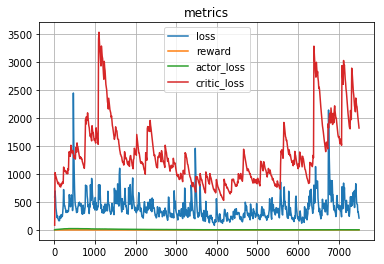

Random session examples.


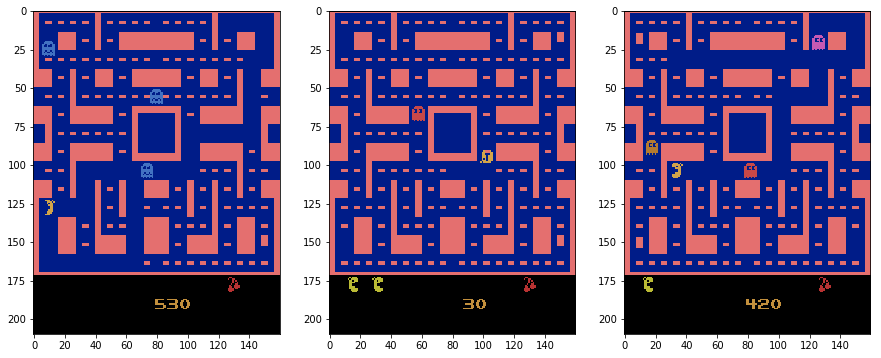

epoch 7510,loss 389.45896 (A: 2.22539, C: 1752.49113), epsilon 0.05025, reward 0.76259
epoch 7520,loss 326.29753 (A: 2.24491, C: 1694.25333), epsilon 0.05024, reward 0.76646
epoch 7530,loss 258.30347 (A: 2.21546, C: 1625.95519), epsilon 0.05024, reward 0.75841
epoch 7540,loss 332.03139 (A: 2.45997, C: 1585.97673), epsilon 0.05024, reward 0.77468
epoch 7550,loss 329.13621 (A: 2.57790, C: 1537.98953), epsilon 0.05024, reward 0.77648
epoch 7560,loss 654.47720 (A: 2.06164, C: 1478.28891), epsilon 0.05023, reward 0.74205
epoch 7570,loss 429.40846 (A: 1.88110, C: 1421.95245), epsilon 0.05023, reward 0.72985
epoch 7580,loss 683.39972 (A: 2.23565, C: 2775.41088), epsilon 0.05023, reward 0.79248
epoch 7590,loss 514.66138 (A: 2.09170, C: 2776.44436), epsilon 0.05023, reward 0.80901
epoch 8030,loss 556.93340 (A: 1.23798, C: 1980.07406), epsilon 0.05015, reward 0.73885
epoch 8040,loss 437.84200 (A: 1.22636, C: 1935.78918), epsilon 0.05015, reward 0.73267
epoch 8050,loss 367.64886 (A: 1.17898, C: 1

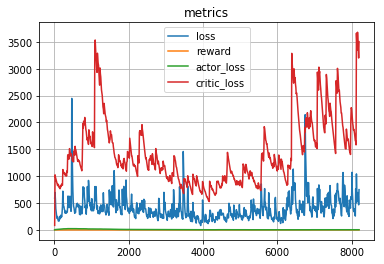

Random session examples.


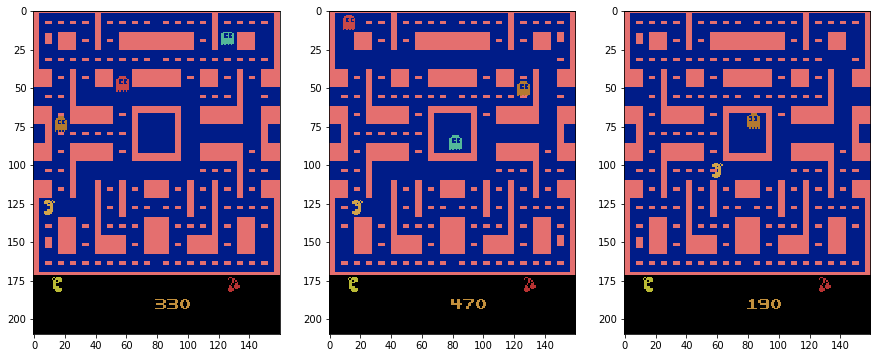

epoch 8210,loss 537.91134 (A: 3.38555, C: 3384.97365), epsilon 0.05012, reward 0.79550
epoch 8220,loss 438.67324 (A: 3.19505, C: 3229.22649), epsilon 0.05012, reward 0.79284
epoch 8230,loss 451.02455 (A: 3.21592, C: 3172.58190), epsilon 0.05012, reward 0.80105
epoch 8870,loss 934.86089 (A: 2.64905, C: 1952.77351), epsilon 0.05006, reward 0.76890
epoch 8880,loss 854.69622 (A: 2.42579, C: 1874.41726), epsilon 0.05006, reward 0.75487
epoch 8890,loss 665.40638 (A: 2.43245, C: 1990.45064), epsilon 0.05006, reward 0.76693
epoch 8900,loss 602.22865 (A: 2.28574, C: 1907.43805), epsilon 0.05006, reward 0.75788
Learning curves:


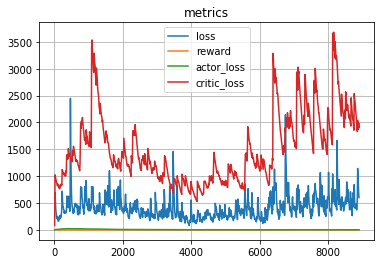

Random session examples.


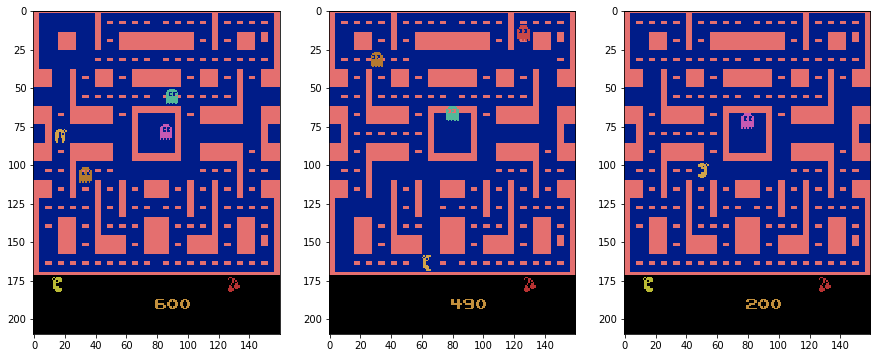

epoch 8910,loss 501.22711 (A: 2.08713, C: 1822.07633), epsilon 0.05006, reward 0.74587
epoch 8920,loss 360.58471 (A: 2.08806, C: 1754.75668), epsilon 0.05006, reward 0.75887
epoch 8930,loss 448.86179 (A: 2.15846, C: 1698.19359), epsilon 0.05006, reward 0.75803
epoch 8940,loss 423.52296 (A: 1.76794, C: 1639.81401), epsilon 0.05006, reward 0.74064
epoch 8950,loss 471.97287 (A: 1.64835, C: 1590.47781), epsilon 0.05006, reward 0.74755
epoch 8960,loss 553.61423 (A: 1.31805, C: 1580.83002), epsilon 0.05006, reward 0.73801
epoch 8970,loss 514.56121 (A: 1.13909, C: 1535.70764), epsilon 0.05006, reward 0.73285
epoch 8980,loss 365.04158 (A: 0.91039, C: 1478.57485), epsilon 0.05006, reward 0.71378
epoch 8990,loss 936.91677 (A: 0.74456, C: 1424.24320), epsilon 0.05006, reward 0.70007
epoch 9000,loss 742.56316 (A: 1.07922, C: 1458.23640), epsilon 0.05006, reward 0.72317
Learning curves:


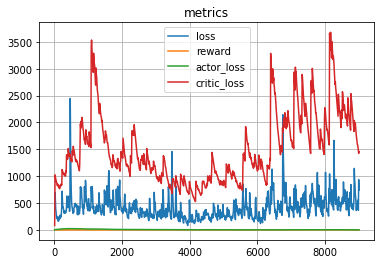

Random session examples.


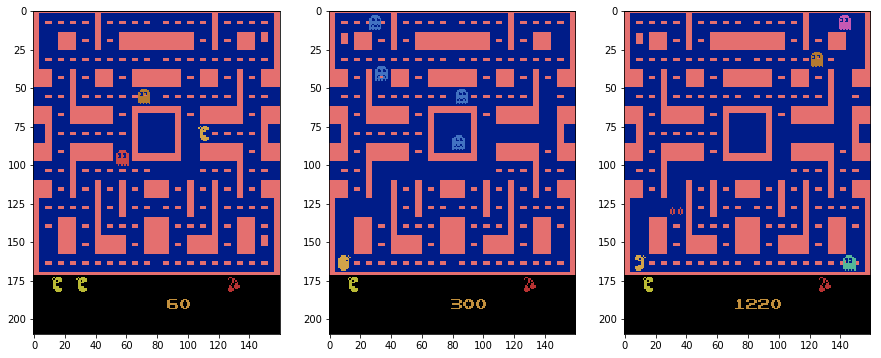

[2017-05-24 21:09:17,873] Making new env: MsPacman-v0
[2017-05-24 21:09:18,035] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 21:09:18,045] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.9.10942.video000000.mp4
[2017-05-24 21:09:21,039] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.9.10942.video000001.mp4


Episode finished after 923 timesteps with reward=180.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 560 timesteps with reward=90.0
Episode finished after 690 timesteps with reward=130.0
Episode finished after 428 timesteps with reward=60.0
Episode finished after 575 timesteps with reward=110.0
Episode finished after 506 timesteps with reward=110.0


[2017-05-24 21:09:31,244] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.9.10942.video000008.mp4


Episode finished after 544 timesteps with reward=60.0
Episode finished after 443 timesteps with reward=90.0
Episode finished after 400 timesteps with reward=180.0
Episode finished after 592 timesteps with reward=110.0
Episode finished after 516 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 648 timesteps with reward=380.0
Episode finished after 520 timesteps with reward=110.0
Episode finished after 562 timesteps with reward=70.0
Episode finished after 437 timesteps with reward=60.0
Episode finished after 514 timesteps with reward=60.0
Episode finished after 429 timesteps with reward=70.0


[2017-05-24 21:09:47,543] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/a2c_videos')


Episode finished after 561 timesteps with reward=180.0
Mean 111.5, Var 5472.75
epoch 9010,loss 638.93583 (A: 1.31031, C: 1460.40424), epsilon 0.05005, reward 0.72314
epoch 9020,loss 521.34823 (A: 1.36216, C: 1459.06142), epsilon 0.05005, reward 0.72800
epoch 9030,loss 440.51794 (A: 1.19545, C: 1399.46701), epsilon 0.05005, reward 0.72041
epoch 9040,loss 496.72895 (A: 1.24666, C: 1404.31756), epsilon 0.05005, reward 0.71857
epoch 9050,loss 1881.77552 (A: 0.95723, C: 1353.24938), epsilon 0.05005, reward 0.70657
epoch 9060,loss 1395.75706 (A: 0.86696, C: 1483.58339), epsilon 0.05005, reward 0.71030
epoch 9070,loss 1281.12796 (A: 1.18385, C: 1501.61623), epsilon 0.05005, reward 0.72068
epoch 9080,loss 900.42276 (A: 1.08609, C: 1451.20511), epsilon 0.05005, reward 0.72078
epoch 9090,loss 2042.74709 (A: 0.96781, C: 1391.42161), epsilon 0.05005, reward 0.70525
epoch 9100,loss 1273.71554 (A: 0.91172, C: 1357.06212), epsilon 0.05005, reward 0.70661
Learning curves:


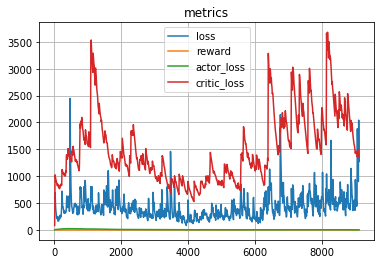

Random session examples.


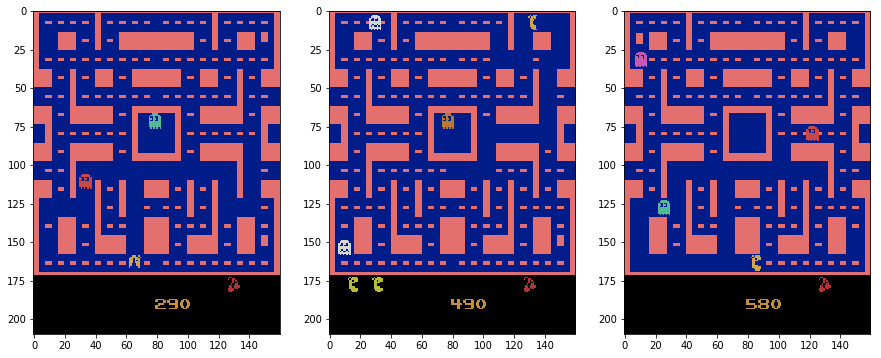

epoch 9110,loss 883.40715 (A: 0.96712, C: 1316.02594), epsilon 0.05005, reward 0.70936
epoch 9120,loss 639.50653 (A: 0.97922, C: 1370.77049), epsilon 0.05005, reward 0.71296
epoch 9130,loss 685.42495 (A: 2.58205, C: 2068.08519), epsilon 0.05005, reward 0.76178
epoch 9140,loss 518.89828 (A: 2.44960, C: 1983.56536), epsilon 0.05005, reward 0.75739
epoch 9150,loss 374.15746 (A: 2.53113, C: 1911.37240), epsilon 0.05005, reward 0.76297
epoch 9160,loss 515.80240 (A: 2.44002, C: 1841.43504), epsilon 0.05005, reward 0.76828
epoch 9170,loss 365.32052 (A: 2.26498, C: 1773.75438), epsilon 0.05005, reward 0.76551
epoch 9180,loss 374.55442 (A: 2.44220, C: 1707.18926), epsilon 0.05005, reward 0.77167
epoch 9190,loss 287.24165 (A: 2.32984, C: 1639.82145), epsilon 0.05005, reward 0.77117
epoch 9200,loss 311.15888 (A: 2.03281, C: 1588.23304), epsilon 0.05005, reward 0.77119
Learning curves:


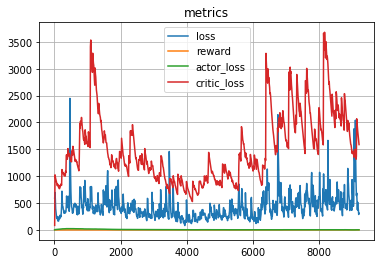

Random session examples.


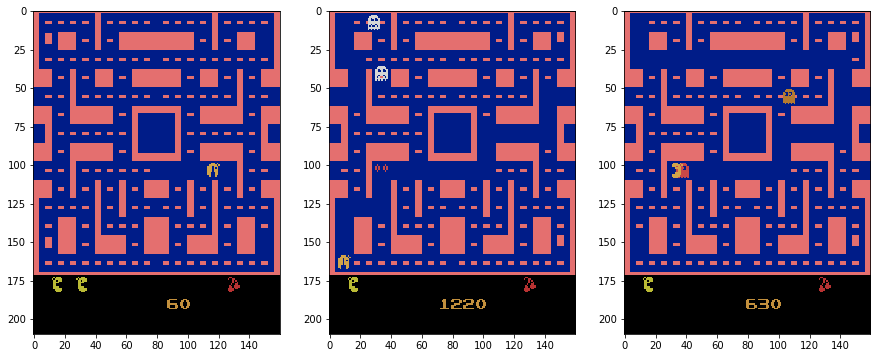

epoch 9210,loss 287.43986 (A: 1.72437, C: 1534.80083), epsilon 0.05005, reward 0.75900
epoch 9220,loss 3151.93149 (A: 4.49748, C: 12546.92250), epsilon 0.05004, reward 0.91148
epoch 9230,loss 2206.49826 (A: 4.26570, C: 11933.41672), epsilon 0.05004, reward 0.88885
epoch 9240,loss 1463.05589 (A: 4.27312, C: 11581.01312), epsilon 0.05004, reward 0.90056
epoch 9250,loss 1110.45682 (A: 3.99123, C: 11011.69168), epsilon 0.05004, reward 0.87995
epoch 9260,loss 938.97339 (A: 4.13682, C: 10631.88560), epsilon 0.05004, reward 0.91212
epoch 9270,loss 836.86681 (A: 3.60586, C: 10119.65751), epsilon 0.05004, reward 0.88409
epoch 9280,loss 566.83966 (A: 3.35294, C: 9622.97422), epsilon 0.05004, reward 0.87163
epoch 9290,loss 603.13125 (A: 3.13758, C: 9159.26372), epsilon 0.05004, reward 0.85441
epoch 9300,loss 521.38165 (A: 2.74032, C: 8717.73288), epsilon 0.05004, reward 0.84001
Learning curves:


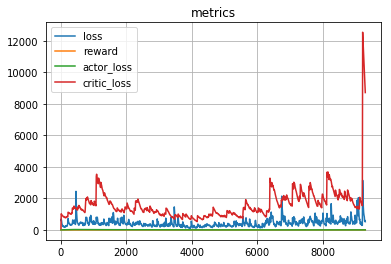

Random session examples.


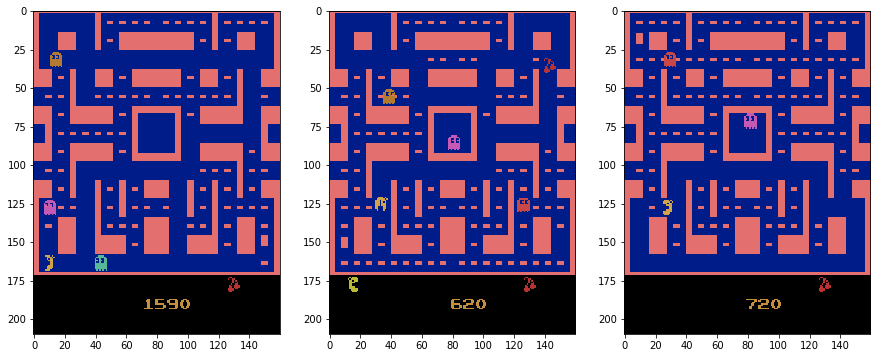

epoch 9310,loss 544.01745 (A: 2.62792, C: 8299.77617), epsilon 0.05004, reward 0.83073
epoch 9320,loss 504.19059 (A: 2.74939, C: 7944.25922), epsilon 0.05004, reward 0.83362
epoch 9330,loss 444.21471 (A: 2.34797, C: 7567.75303), epsilon 0.05004, reward 0.81392
epoch 9340,loss 466.84055 (A: 2.88197, C: 7502.73005), epsilon 0.05004, reward 0.83816
epoch 9350,loss 873.42360 (A: 4.51542, C: 8254.01591), epsilon 0.05004, reward 0.93737
epoch 9360,loss 621.30558 (A: 4.20866, C: 7867.22901), epsilon 0.05004, reward 0.92272
epoch 9370,loss 472.58297 (A: 3.70527, C: 7485.90124), epsilon 0.05004, reward 0.89954
epoch 9380,loss 572.65853 (A: 3.79613, C: 7474.10918), epsilon 0.05004, reward 0.94343
epoch 9390,loss 429.88683 (A: 3.09689, C: 7119.43730), epsilon 0.05004, reward 0.91091
epoch 9400,loss 337.38256 (A: 3.04853, C: 6779.75606), epsilon 0.05004, reward 0.89466
Learning curves:


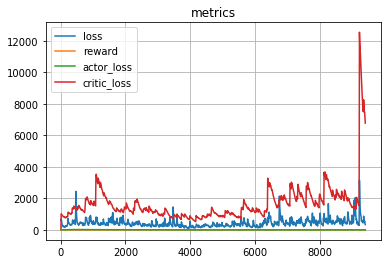

Random session examples.


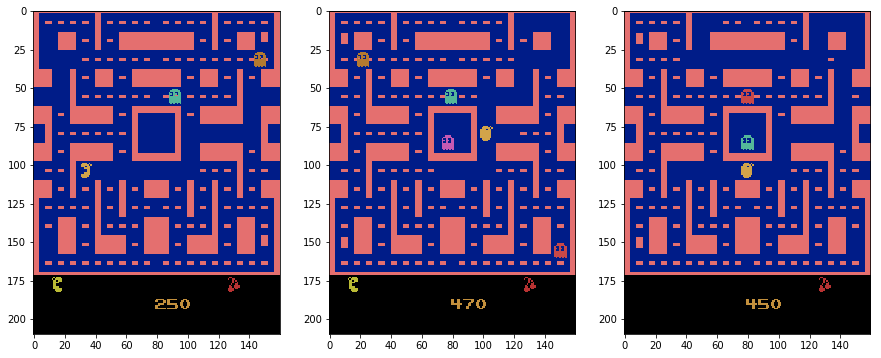

epoch 9410,loss 300.19551 (A: 2.97425, C: 6461.64256), epsilon 0.05004, reward 0.89192
epoch 9420,loss 281.36618 (A: 3.07362, C: 6321.69791), epsilon 0.05004, reward 0.90152
epoch 9430,loss 354.35485 (A: 2.83976, C: 6021.99810), epsilon 0.05004, reward 0.88818
epoch 9440,loss 682.96133 (A: 3.09163, C: 5832.32873), epsilon 0.05004, reward 0.88918
epoch 9450,loss 487.66982 (A: 3.14781, C: 5562.50733), epsilon 0.05004, reward 0.88672
epoch 9460,loss 399.96912 (A: 2.97053, C: 5305.71268), epsilon 0.05004, reward 0.87949
epoch 9470,loss 391.02684 (A: 2.63764, C: 5058.77213), epsilon 0.05003, reward 0.86335
epoch 9480,loss 822.25694 (A: 3.02463, C: 5063.32152), epsilon 0.05003, reward 0.87780
epoch 9490,loss 1104.18391 (A: 2.69445, C: 4831.26382), epsilon 0.05003, reward 0.85881
epoch 9500,loss 1140.17334 (A: 3.07959, C: 5463.06938), epsilon 0.05003, reward 0.87788
Learning curves:


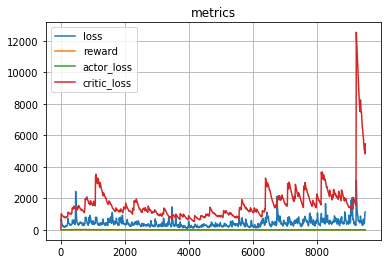

Random session examples.


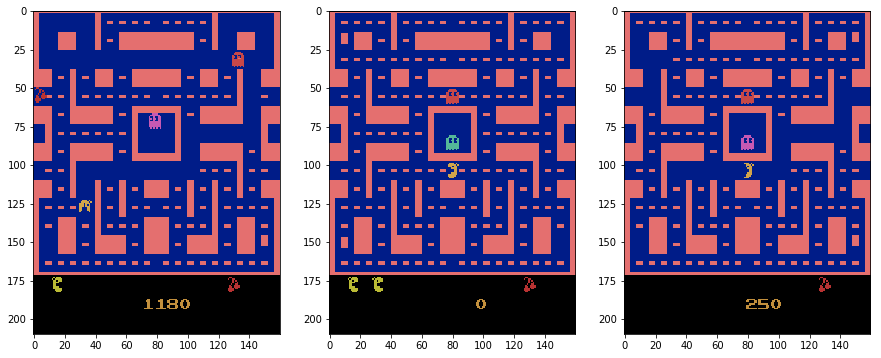

epoch 9510,loss 841.12500 (A: 3.61520, C: 5370.55443), epsilon 0.05003, reward 0.90625
epoch 9520,loss 730.30052 (A: 3.58015, C: 5177.08929), epsilon 0.05003, reward 0.90293
epoch 9530,loss 871.65249 (A: 3.00684, C: 4935.73044), epsilon 0.05003, reward 0.86950
epoch 9540,loss 1640.48425 (A: 3.02876, C: 4744.60993), epsilon 0.05003, reward 0.86851
epoch 9550,loss 1197.39899 (A: 2.93004, C: 4558.51756), epsilon 0.05003, reward 0.89979
epoch 9560,loss 902.21162 (A: 2.74504, C: 4356.75343), epsilon 0.05003, reward 0.88019
epoch 9570,loss 1136.11244 (A: 2.70040, C: 4153.12132), epsilon 0.05003, reward 0.87476
epoch 9580,loss 1058.73364 (A: 2.66764, C: 4086.01601), epsilon 0.05003, reward 0.87106
epoch 9590,loss 709.18938 (A: 2.90639, C: 3927.81910), epsilon 0.05003, reward 0.87877
epoch 9600,loss 1374.82459 (A: 3.04800, C: 3816.96960), epsilon 0.05003, reward 0.87536
Learning curves:


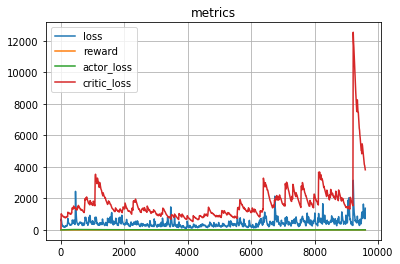

Random session examples.


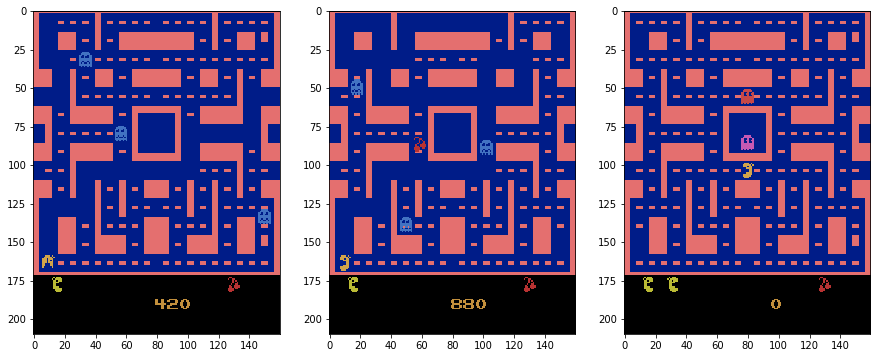

epoch 9610,loss 1217.19872 (A: 3.25756, C: 3658.72376), epsilon 0.05003, reward 0.88335
epoch 9620,loss 938.34247 (A: 3.08772, C: 3527.22871), epsilon 0.05003, reward 0.87434
epoch 9630,loss 730.98746 (A: 3.07275, C: 3373.77639), epsilon 0.05003, reward 0.87213
epoch 9640,loss 1023.80770 (A: 3.43417, C: 3460.78794), epsilon 0.05003, reward 0.90811
epoch 9650,loss 746.79362 (A: 2.90268, C: 3307.66828), epsilon 0.05003, reward 0.87687
epoch 9660,loss 726.88079 (A: 3.60921, C: 3859.69380), epsilon 0.05003, reward 0.93459
epoch 9670,loss 601.66317 (A: 3.33255, C: 3759.88214), epsilon 0.05003, reward 0.91959
epoch 9680,loss 440.72059 (A: 3.26368, C: 3609.45103), epsilon 0.05003, reward 0.91707
epoch 9690,loss 359.33055 (A: 3.20394, C: 3507.81530), epsilon 0.05003, reward 0.91907
epoch 9700,loss 349.36705 (A: 3.40901, C: 3402.30015), epsilon 0.05003, reward 0.91267
Learning curves:


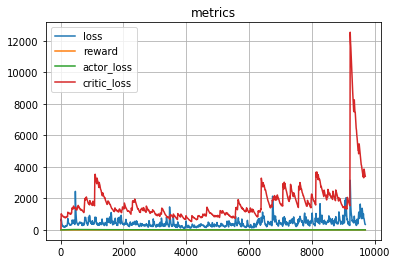

Random session examples.


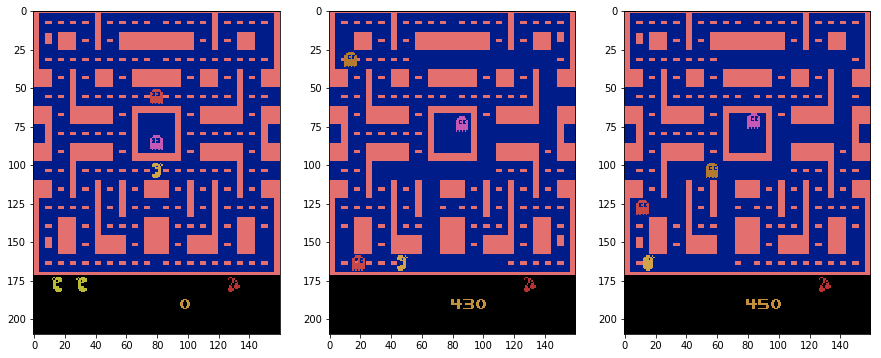

epoch 9710,loss 462.56443 (A: 3.19408, C: 3248.02562), epsilon 0.05003, reward 0.89731
epoch 9720,loss 473.46529 (A: 3.43356, C: 3393.63345), epsilon 0.05003, reward 0.91738
epoch 9730,loss 427.25570 (A: 3.07859, C: 3239.14985), epsilon 0.05003, reward 0.89007
epoch 9740,loss 503.63487 (A: 2.88706, C: 3087.04689), epsilon 0.05003, reward 0.87486
epoch 9750,loss 630.87018 (A: 3.07943, C: 3034.07983), epsilon 0.05003, reward 0.88239
epoch 9760,loss 1704.64406 (A: 3.17677, C: 2931.14974), epsilon 0.05003, reward 0.88124
epoch 9770,loss 1159.49447 (A: 2.95902, C: 2795.59234), epsilon 0.05003, reward 0.86305
epoch 9780,loss 895.23565 (A: 2.95626, C: 2732.23913), epsilon 0.05003, reward 0.86043
epoch 9790,loss 712.79316 (A: 3.02270, C: 2616.79621), epsilon 0.05003, reward 0.86086
epoch 9800,loss 630.59575 (A: 2.73263, C: 2501.95710), epsilon 0.05002, reward 0.84907
Learning curves:


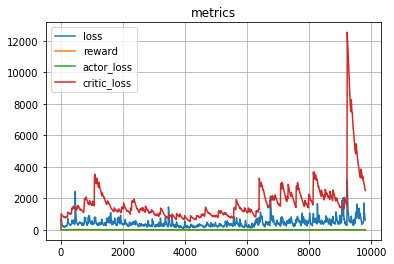

Random session examples.


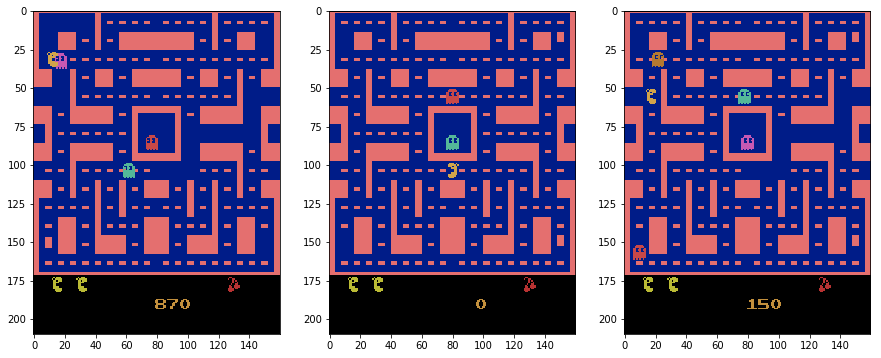

epoch 9810,loss 601.31288 (A: 3.54614, C: 2576.91808), epsilon 0.05002, reward 0.87937
epoch 9820,loss 546.81966 (A: 3.50257, C: 2483.37713), epsilon 0.05002, reward 0.87935
epoch 9830,loss 733.86531 (A: 3.29860, C: 2411.98932), epsilon 0.05002, reward 0.86663
epoch 9840,loss 534.48948 (A: 3.01101, C: 2303.92462), epsilon 0.05002, reward 0.85357
epoch 9850,loss 386.66476 (A: 2.85976, C: 2208.82640), epsilon 0.05002, reward 0.84068
epoch 9860,loss 335.45720 (A: 2.86444, C: 2145.90189), epsilon 0.05002, reward 0.83917
epoch 9870,loss 452.52850 (A: 4.05743, C: 2768.65133), epsilon 0.05002, reward 0.88462
epoch 9880,loss 320.40477 (A: 3.75216, C: 2664.69172), epsilon 0.05002, reward 0.87115
epoch 9890,loss 247.07479 (A: 3.43040, C: 2555.04604), epsilon 0.05002, reward 0.86079
epoch 9900,loss 521.65902 (A: 3.70538, C: 2510.77761), epsilon 0.05002, reward 0.87195
Learning curves:


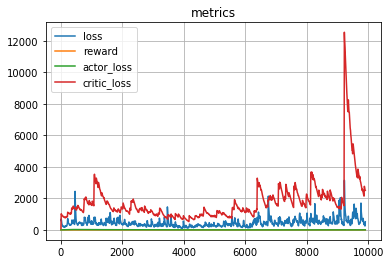

Random session examples.


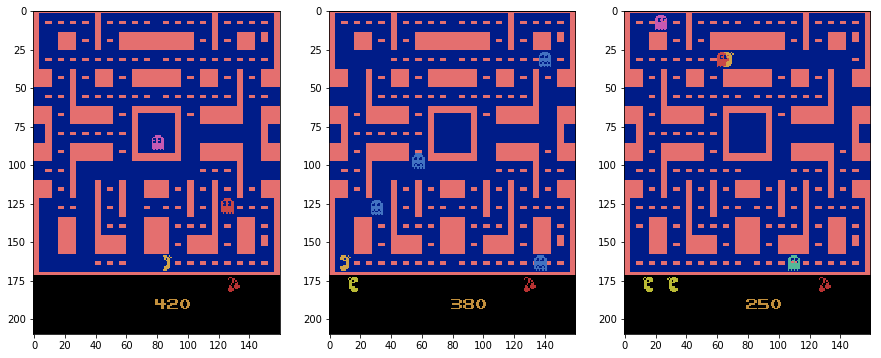

epoch 9910,loss 412.58550 (A: 3.45787, C: 2395.14639), epsilon 0.05002, reward 0.86253
epoch 9920,loss 668.91819 (A: 4.45433, C: 3651.29835), epsilon 0.05002, reward 0.90290
epoch 9930,loss 635.31649 (A: 4.21662, C: 3480.03461), epsilon 0.05002, reward 0.89145
epoch 9940,loss 456.62593 (A: 4.12836, C: 3341.82401), epsilon 0.05002, reward 0.89619
epoch 9950,loss 800.37311 (A: 3.71140, C: 3186.80183), epsilon 0.05002, reward 0.87092
epoch 9960,loss 786.93145 (A: 3.93705, C: 3110.10765), epsilon 0.05002, reward 0.87327
epoch 9970,loss 631.42436 (A: 3.75281, C: 2978.54963), epsilon 0.05002, reward 0.85890
epoch 9980,loss 491.05608 (A: 3.51246, C: 2894.94583), epsilon 0.05002, reward 0.84818
epoch 9990,loss 512.93014 (A: 3.34904, C: 2770.49488), epsilon 0.05002, reward 0.83995
epoch 10000,loss 2202.19806 (A: 3.34107, C: 2694.18161), epsilon 0.05002, reward 0.83751
Learning curves:


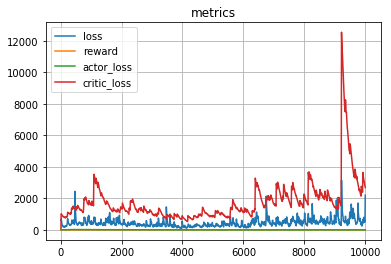

Random session examples.


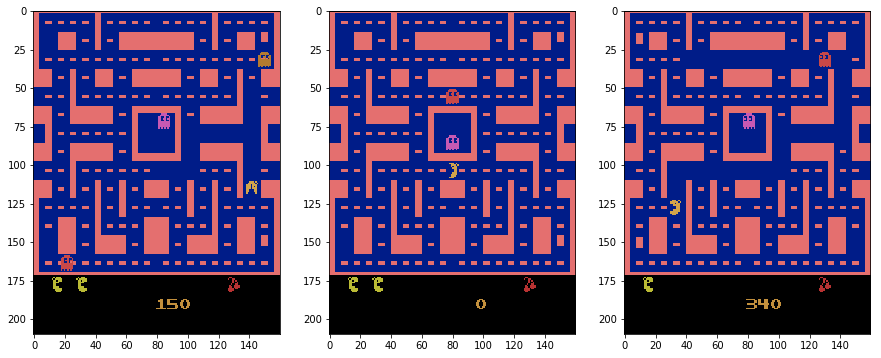

[2017-05-24 22:57:00,845] Making new env: MsPacman-v0
[2017-05-24 22:57:01,008] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 22:57:01,018] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.10.10942.video000000.mp4
[2017-05-24 22:57:02,524] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.10.10942.video000001.mp4


Episode finished after 437 timesteps with reward=60.0
Episode finished after 421 timesteps with reward=60.0
Episode finished after 568 timesteps with reward=110.0
Episode finished after 786 timesteps with reward=380.0
Episode finished after 846 timesteps with reward=780.0
Episode finished after 823 timesteps with reward=830.0
Episode finished after 528 timesteps with reward=60.0


[2017-05-24 22:57:14,819] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.10.10942.video000008.mp4


Episode finished after 435 timesteps with reward=60.0
Episode finished after 438 timesteps with reward=60.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 485 timesteps with reward=90.0
Episode finished after 451 timesteps with reward=70.0
Episode finished after 560 timesteps with reward=90.0
Episode finished after 697 timesteps with reward=180.0
Episode finished after 942 timesteps with reward=380.0
Episode finished after 719 timesteps with reward=180.0
Episode finished after 766 timesteps with reward=210.0
Episode finished after 466 timesteps with reward=110.0
Episode finished after 419 timesteps with reward=70.0


[2017-05-24 22:57:33,865] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/a2c_videos')


Episode finished after 432 timesteps with reward=60.0
Mean 195.0, Var 50495.0
epoch 10010,loss 1386.90976 (A: 3.27379, C: 2594.71431), epsilon 0.05002, reward 0.83860
epoch 10020,loss 965.56926 (A: 2.96670, C: 2474.16551), epsilon 0.05002, reward 0.82792
epoch 10030,loss 948.61666 (A: 3.00704, C: 2665.76683), epsilon 0.05002, reward 0.85928
epoch 10040,loss 640.57635 (A: 2.73012, C: 2545.27326), epsilon 0.05002, reward 0.83975
epoch 10050,loss 501.18691 (A: 2.47162, C: 2462.66449), epsilon 0.05002, reward 0.82315
epoch 10060,loss 412.45775 (A: 2.91738, C: 2478.89715), epsilon 0.05002, reward 0.84010
epoch 10070,loss 660.73761 (A: 2.72128, C: 2393.49109), epsilon 0.05002, reward 0.83765
epoch 10080,loss 524.30942 (A: 2.57183, C: 2334.26044), epsilon 0.05002, reward 0.82555
epoch 10090,loss 517.51144 (A: 2.64693, C: 2281.16713), epsilon 0.05002, reward 0.82773
epoch 10100,loss 399.77950 (A: 2.09816, C: 2197.20931), epsilon 0.05002, reward 0.81125
Learning curves:


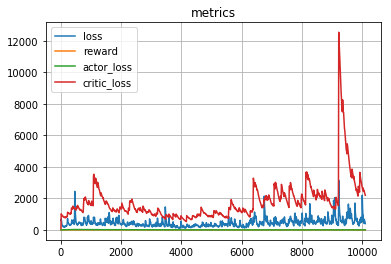

Random session examples.


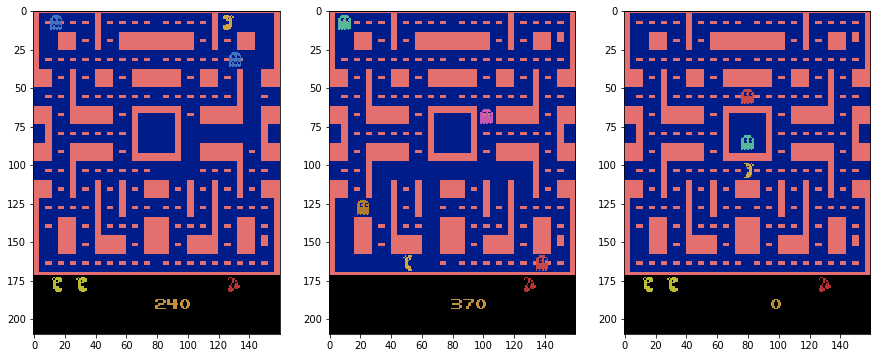

epoch 10110,loss 380.38770 (A: 1.76318, C: 2104.47703), epsilon 0.05002, reward 0.79119
epoch 10120,loss 452.38184 (A: 2.15316, C: 2074.82047), epsilon 0.05002, reward 0.79802
epoch 10130,loss 344.50016 (A: 2.13955, C: 2004.61629), epsilon 0.05002, reward 0.80304
epoch 10140,loss 421.87206 (A: 2.17762, C: 2039.52708), epsilon 0.05002, reward 0.80488
epoch 10150,loss 462.95905 (A: 2.31182, C: 1964.35934), epsilon 0.05002, reward 0.81591
epoch 10160,loss 454.32007 (A: 2.25933, C: 1890.74651), epsilon 0.05002, reward 0.80343
epoch 10170,loss 455.30717 (A: 1.81666, C: 1817.65017), epsilon 0.05002, reward 0.78426
epoch 10180,loss 393.26313 (A: 1.97459, C: 1907.29703), epsilon 0.05002, reward 0.78508
epoch 10190,loss 383.70479 (A: 1.64860, C: 1831.58218), epsilon 0.05002, reward 0.76975
epoch 10200,loss 465.07619 (A: 1.25996, C: 1750.16393), epsilon 0.05002, reward 0.74640
Learning curves:


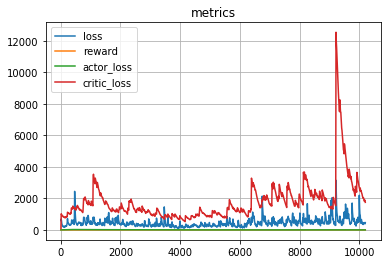

Random session examples.


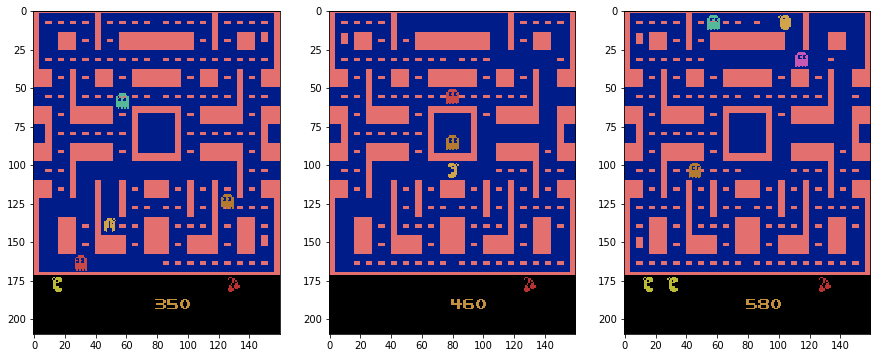

epoch 10210,loss 351.60731 (A: 2.05227, C: 1749.92825), epsilon 0.05002, reward 0.77109
epoch 10220,loss 367.36853 (A: 1.95558, C: 1704.54076), epsilon 0.05002, reward 0.77160
epoch 10230,loss 616.44289 (A: 1.53975, C: 1633.61430), epsilon 0.05002, reward 0.74718
epoch 10240,loss 573.01125 (A: 1.44083, C: 1572.98722), epsilon 0.05002, reward 0.74400
epoch 10250,loss 460.06416 (A: 1.21178, C: 1551.98775), epsilon 0.05002, reward 0.74489
epoch 10260,loss 474.59906 (A: 1.61284, C: 1776.98858), epsilon 0.05002, reward 0.77014
epoch 10270,loss 385.08009 (A: 1.59703, C: 1718.63263), epsilon 0.05002, reward 0.76386
epoch 10280,loss 367.64204 (A: 1.22131, C: 1656.23814), epsilon 0.05002, reward 0.74276
epoch 10290,loss 330.99323 (A: 0.97473, C: 1596.60352), epsilon 0.05002, reward 0.74322
epoch 10300,loss 580.10763 (A: 1.77315, C: 1861.83572), epsilon 0.05002, reward 0.78907
Learning curves:


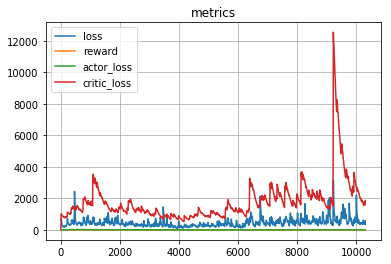

Random session examples.


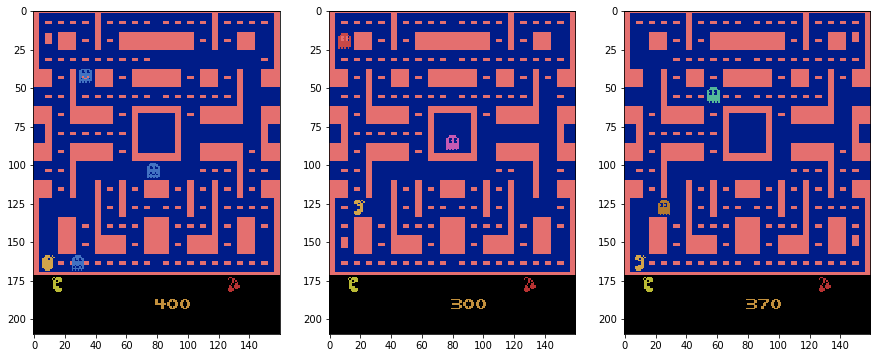

epoch 10310,loss 594.05544 (A: 1.77821, C: 1788.65580), epsilon 0.05001, reward 0.79405
epoch 10320,loss 798.11035 (A: 2.50027, C: 1938.98575), epsilon 0.05001, reward 0.81489
epoch 10330,loss 526.24502 (A: 2.12119, C: 1860.71431), epsilon 0.05001, reward 0.80149
epoch 10340,loss 650.75374 (A: 2.36600, C: 2077.32446), epsilon 0.05001, reward 0.81122
epoch 10350,loss 831.70597 (A: 2.18431, C: 2038.90681), epsilon 0.05001, reward 0.79947
epoch 10360,loss 831.87800 (A: 2.00131, C: 1972.35719), epsilon 0.05001, reward 0.80198
epoch 10370,loss 708.20974 (A: 1.89919, C: 1890.89129), epsilon 0.05001, reward 0.79459
epoch 10380,loss 1278.77630 (A: 1.61698, C: 1817.34375), epsilon 0.05001, reward 0.78660
epoch 10390,loss 944.61846 (A: 1.51338, C: 1803.53674), epsilon 0.05001, reward 0.78487
epoch 10400,loss 628.93368 (A: 1.36732, C: 1734.51446), epsilon 0.05001, reward 0.77297
Learning curves:


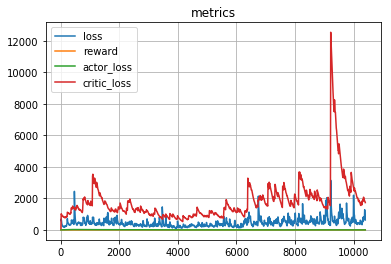

Random session examples.


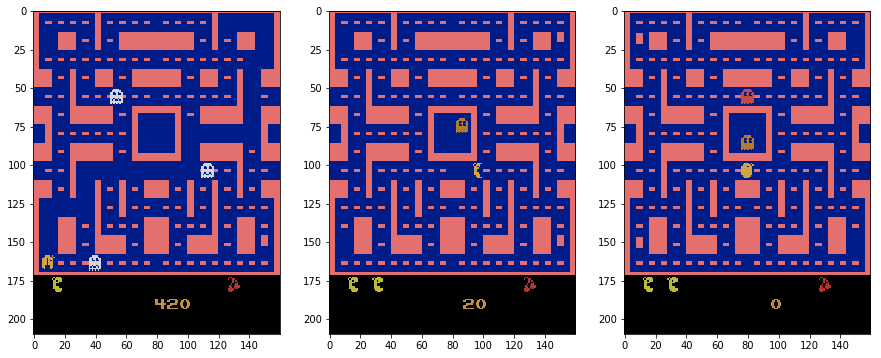

epoch 10410,loss 486.45846 (A: 1.11809, C: 1668.98322), epsilon 0.05001, reward 0.76655
epoch 10420,loss 360.60005 (A: 1.02264, C: 1608.30664), epsilon 0.05001, reward 0.76826
epoch 10430,loss 369.99719 (A: 1.40817, C: 1653.05527), epsilon 0.05001, reward 0.77379
epoch 10440,loss 453.68708 (A: 2.47398, C: 2224.03727), epsilon 0.05001, reward 0.82690
epoch 10450,loss 469.92496 (A: 2.58741, C: 2161.35835), epsilon 0.05001, reward 0.83096
epoch 10460,loss 590.51933 (A: 2.64445, C: 2073.54319), epsilon 0.05001, reward 0.82213
epoch 10470,loss 666.24106 (A: 2.12959, C: 1988.09411), epsilon 0.05001, reward 0.80495
epoch 10480,loss 516.16992 (A: 2.04297, C: 1912.55773), epsilon 0.05001, reward 0.79449
epoch 10490,loss 388.32542 (A: 1.92879, C: 1847.68261), epsilon 0.05001, reward 0.78943
epoch 10500,loss 320.42521 (A: 2.25477, C: 1786.27344), epsilon 0.05001, reward 0.80318
Learning curves:


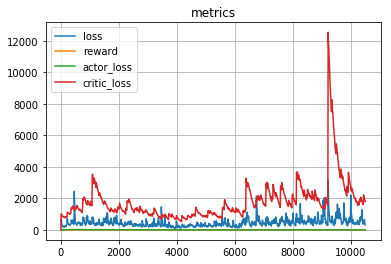

Random session examples.


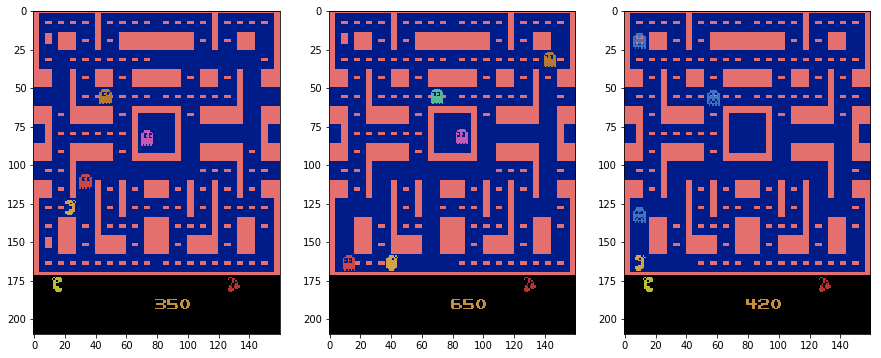

epoch 10510,loss 301.01014 (A: 2.33006, C: 1724.21104), epsilon 0.05001, reward 0.81771
epoch 10520,loss 726.01719 (A: 1.99626, C: 1757.18148), epsilon 0.05001, reward 0.82175
epoch 10530,loss 606.58877 (A: 2.15400, C: 1758.16296), epsilon 0.05001, reward 0.84169
epoch 10540,loss 426.07876 (A: 2.04177, C: 1707.28142), epsilon 0.05001, reward 0.84795
epoch 10550,loss 420.30527 (A: 2.37197, C: 1902.89144), epsilon 0.05001, reward 0.87293
epoch 10560,loss 395.74727 (A: 2.74548, C: 1921.65604), epsilon 0.05001, reward 0.90888
epoch 10570,loss 301.72270 (A: 2.84197, C: 1856.65258), epsilon 0.05001, reward 0.91324
epoch 10580,loss 382.04466 (A: 3.12878, C: 1883.02205), epsilon 0.05001, reward 0.92226
epoch 10590,loss 295.98545 (A: 3.25556, C: 1819.53289), epsilon 0.05001, reward 0.93133
epoch 10600,loss 287.59784 (A: 3.48266, C: 1763.82592), epsilon 0.05001, reward 0.94580
Learning curves:


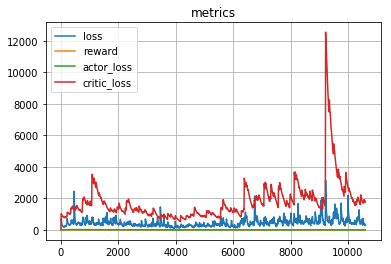

Random session examples.


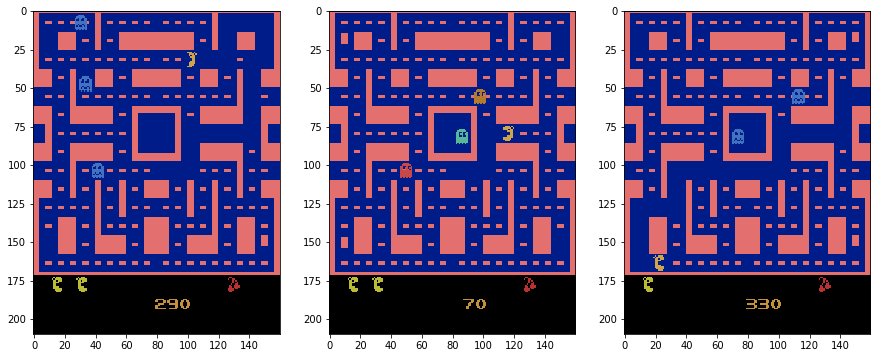

epoch 10610,loss 372.20724 (A: 3.67138, C: 2164.47827), epsilon 0.05001, reward 0.96589
epoch 10620,loss 650.05290 (A: 3.43850, C: 2071.26083), epsilon 0.05001, reward 0.95031
epoch 10630,loss 505.20486 (A: 3.07832, C: 1982.80316), epsilon 0.05001, reward 0.92770
epoch 10640,loss 422.55300 (A: 2.57422, C: 1901.58772), epsilon 0.05001, reward 0.90133
epoch 10650,loss 385.38719 (A: 2.48725, C: 1826.22134), epsilon 0.05001, reward 0.89484
epoch 10660,loss 362.91469 (A: 2.55157, C: 1809.70163), epsilon 0.05001, reward 0.89404
epoch 10670,loss 604.14525 (A: 4.02504, C: 2447.60664), epsilon 0.05001, reward 0.93821
epoch 10680,loss 1068.00555 (A: 5.23625, C: 4144.76966), epsilon 0.05001, reward 0.98944
epoch 10690,loss 764.34567 (A: 4.70274, C: 3967.64377), epsilon 0.05001, reward 0.96975
epoch 10700,loss 537.52601 (A: 4.25306, C: 3790.92986), epsilon 0.05001, reward 0.94568
Learning curves:


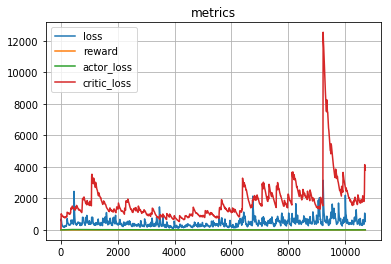

Random session examples.


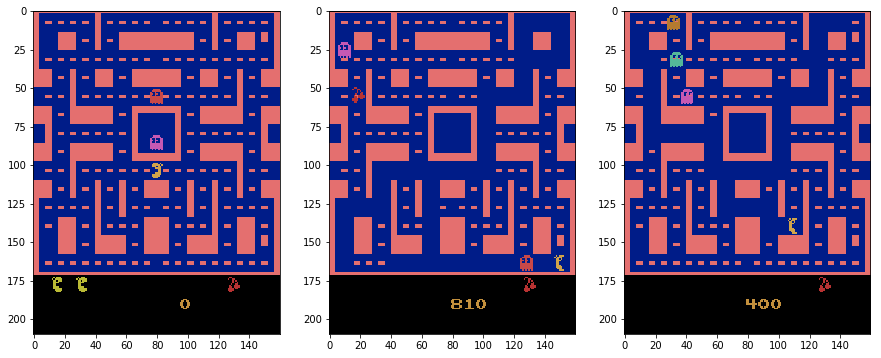

epoch 10710,loss 454.90222 (A: 3.81534, C: 3619.06108), epsilon 0.05001, reward 0.92330
epoch 10720,loss 570.21632 (A: 3.26011, C: 3456.25482), epsilon 0.05001, reward 0.90155
epoch 10730,loss 637.18996 (A: 3.00321, C: 3324.38237), epsilon 0.05001, reward 0.89553
epoch 10740,loss 531.06163 (A: 3.04211, C: 3272.00270), epsilon 0.05001, reward 0.88982
epoch 10750,loss 597.52665 (A: 2.68420, C: 3155.68432), epsilon 0.05001, reward 0.88000
epoch 10760,loss 661.89753 (A: 2.17675, C: 3012.42543), epsilon 0.05001, reward 0.86529
epoch 10770,loss 542.81190 (A: 1.73479, C: 2888.76095), epsilon 0.05001, reward 0.85474
epoch 10780,loss 837.36216 (A: 1.78755, C: 2807.14210), epsilon 0.05001, reward 0.86718
epoch 10790,loss 566.34376 (A: 1.42384, C: 2679.96849), epsilon 0.05001, reward 0.84921
epoch 10800,loss 689.17916 (A: 1.46495, C: 2677.77761), epsilon 0.05001, reward 0.84435
Learning curves:


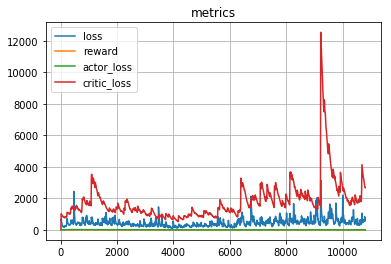

Random session examples.


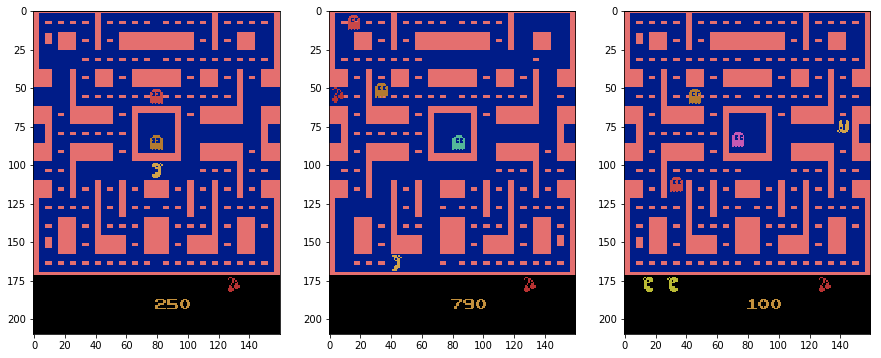

epoch 10810,loss 507.77941 (A: 1.11929, C: 2556.39411), epsilon 0.05001, reward 0.81580
epoch 10820,loss 472.68132 (A: 0.93544, C: 2466.14553), epsilon 0.05001, reward 0.81017
epoch 10830,loss 388.34210 (A: 1.31860, C: 2372.89454), epsilon 0.05001, reward 0.82435
epoch 10840,loss 594.03329 (A: 0.66886, C: 2288.32927), epsilon 0.05001, reward 0.81243
epoch 10850,loss 542.33064 (A: 1.22222, C: 2438.93341), epsilon 0.05001, reward 0.83333
epoch 10860,loss 461.36080 (A: 1.84972, C: 2417.24986), epsilon 0.05001, reward 0.85319
epoch 10870,loss 454.35033 (A: 1.81963, C: 2350.84175), epsilon 0.05001, reward 0.84910
epoch 10880,loss 955.90215 (A: 2.48892, C: 2686.33853), epsilon 0.05001, reward 0.89210
epoch 10890,loss 1113.23203 (A: 3.17387, C: 3975.73167), epsilon 0.05001, reward 0.94417
epoch 10900,loss 931.02683 (A: 3.37151, C: 4045.69870), epsilon 0.05001, reward 0.95067
Learning curves:


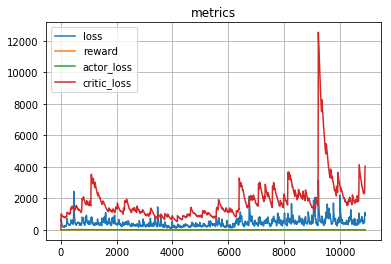

Random session examples.


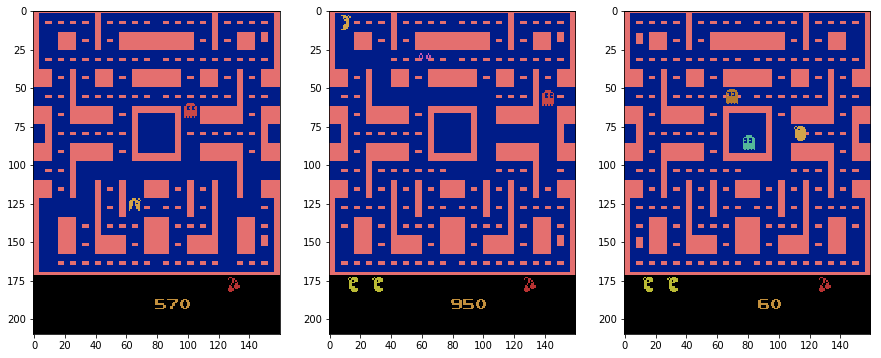

epoch 10910,loss 781.93373 (A: 2.95593, C: 3858.20448), epsilon 0.05001, reward 0.92609
epoch 10920,loss 639.03940 (A: 3.37478, C: 4038.66103), epsilon 0.05001, reward 0.93740
epoch 10930,loss 548.08190 (A: 2.92082, C: 3851.27440), epsilon 0.05001, reward 0.90665
epoch 10940,loss 389.95545 (A: 2.80519, C: 3688.64867), epsilon 0.05001, reward 0.90184
epoch 10950,loss 509.98245 (A: 3.28366, C: 3630.44433), epsilon 0.05001, reward 0.92608
epoch 10960,loss 514.46468 (A: 3.33594, C: 3463.03399), epsilon 0.05001, reward 0.91738
epoch 10970,loss 1308.63287 (A: 5.16474, C: 5603.32448), epsilon 0.05001, reward 1.01018
epoch 10980,loss 917.06889 (A: 5.18856, C: 5347.29499), epsilon 0.05001, reward 1.00899
epoch 10990,loss 855.89121 (A: 5.11137, C: 5193.70166), epsilon 0.05001, reward 0.99760
epoch 11000,loss 596.94932 (A: 4.65180, C: 5028.39371), epsilon 0.05001, reward 0.99118
Learning curves:


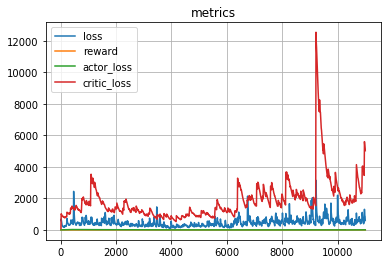

Random session examples.


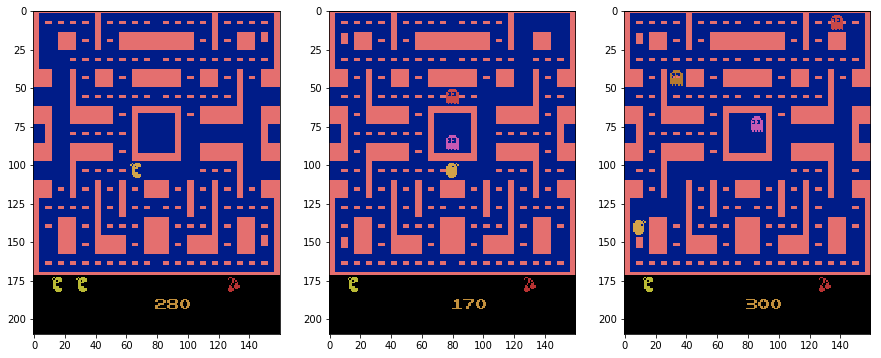

[2017-05-25 00:44:34,843] Making new env: MsPacman-v0
[2017-05-25 00:44:35,103] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-25 00:44:35,113] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.11.10942.video000000.mp4
[2017-05-25 00:44:36,799] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.11.10942.video000001.mp4


Episode finished after 519 timesteps with reward=110.0
Episode finished after 426 timesteps with reward=60.0
Episode finished after 774 timesteps with reward=380.0
Episode finished after 916 timesteps with reward=180.0
Episode finished after 647 timesteps with reward=160.0
Episode finished after 607 timesteps with reward=110.0
Episode finished after 426 timesteps with reward=60.0


[2017-05-25 00:44:48,376] Starting new video recorder writing to /home/vishimtsev/folder/a2c_videos/openaigym.video.11.10942.video000008.mp4


Episode finished after 419 timesteps with reward=110.0
Episode finished after 455 timesteps with reward=110.0
Episode finished after 578 timesteps with reward=110.0
Episode finished after 435 timesteps with reward=60.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 434 timesteps with reward=60.0
Episode finished after 544 timesteps with reward=120.0
Episode finished after 427 timesteps with reward=60.0
Episode finished after 466 timesteps with reward=130.0
Episode finished after 463 timesteps with reward=110.0
Episode finished after 851 timesteps with reward=830.0
Episode finished after 758 timesteps with reward=380.0


[2017-05-25 00:45:05,709] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/a2c_videos')


Episode finished after 564 timesteps with reward=110.0
Mean 165.5, Var 31274.75
epoch 11010,loss 483.65503 (A: 4.61320, C: 4932.10554), epsilon 0.05001, reward 0.99875
epoch 11020,loss 553.60473 (A: 4.41508, C: 4711.87710), epsilon 0.05001, reward 0.98739
epoch 11030,loss 535.91044 (A: 4.00892, C: 4496.30594), epsilon 0.05001, reward 0.96536
epoch 11040,loss 424.30867 (A: 3.59057, C: 4292.77842), epsilon 0.05001, reward 0.94492
epoch 11050,loss 431.80483 (A: 4.22438, C: 4315.12541), epsilon 0.05001, reward 0.95188
epoch 11060,loss 568.77363 (A: 4.33045, C: 4205.33467), epsilon 0.05001, reward 0.95018
epoch 11070,loss 588.96360 (A: 3.38796, C: 4030.60921), epsilon 0.05001, reward 0.92172
epoch 11080,loss 580.18262 (A: 3.77844, C: 4208.24582), epsilon 0.05001, reward 0.94887
epoch 11090,loss 499.87800 (A: 3.58297, C: 4013.40482), epsilon 0.05001, reward 0.93903
epoch 11100,loss 506.11158 (A: 3.47985, C: 3871.31286), epsilon 0.05001, reward 0.93846
Learning curves:


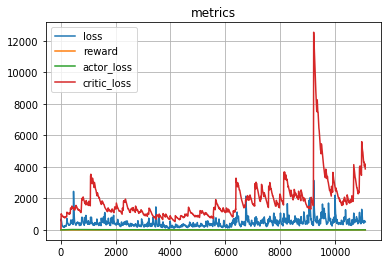

Random session examples.


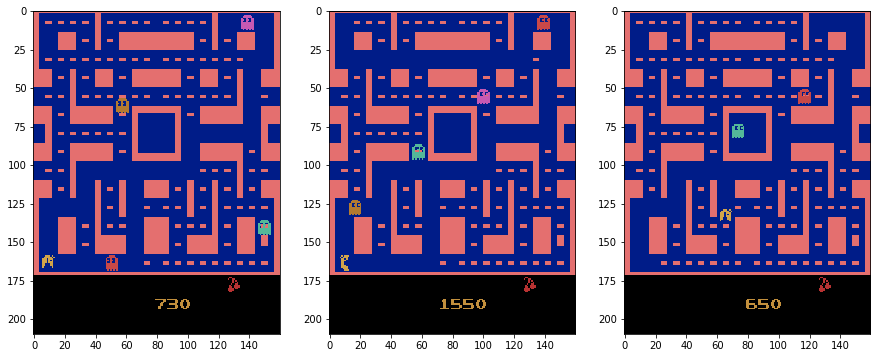

epoch 11110,loss 389.51306 (A: 3.09568, C: 3696.19184), epsilon 0.05001, reward 0.92474
epoch 11120,loss 506.76292 (A: 2.93059, C: 3546.57738), epsilon 0.05001, reward 0.91513
epoch 11130,loss 358.80425 (A: 2.89926, C: 3410.73091), epsilon 0.05001, reward 0.91038
epoch 11140,loss 332.58726 (A: 2.87561, C: 3271.54969), epsilon 0.05001, reward 0.90393
epoch 11150,loss 775.60117 (A: 1.98230, C: 3142.32221), epsilon 0.05001, reward 0.87631
epoch 11160,loss 634.31569 (A: 2.22183, C: 3244.09680), epsilon 0.05001, reward 0.88621
epoch 11170,loss 545.89126 (A: 2.63852, C: 3197.17138), epsilon 0.05001, reward 0.89121
epoch 11180,loss 396.22980 (A: 2.47413, C: 3062.60256), epsilon 0.05001, reward 0.87937
epoch 11190,loss 343.94997 (A: 2.28716, C: 2924.51502), epsilon 0.05001, reward 0.86421
epoch 11200,loss 312.86431 (A: 2.22358, C: 2808.17886), epsilon 0.05001, reward 0.85029
Learning curves:


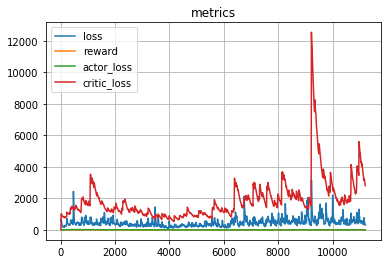

Random session examples.


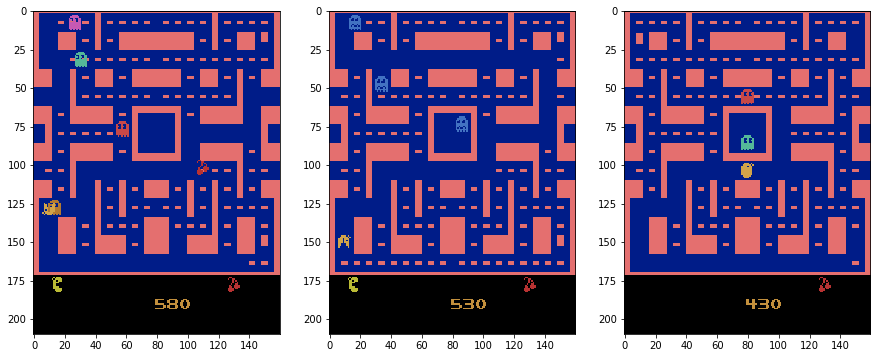

epoch 11210,loss 406.84857 (A: 2.45028, C: 2725.05965), epsilon 0.05001, reward 0.86002
epoch 11220,loss 588.24751 (A: 1.63638, C: 2615.14416), epsilon 0.05001, reward 0.83069
epoch 11230,loss 466.31827 (A: 1.54707, C: 2507.20232), epsilon 0.05001, reward 0.82627
epoch 11240,loss 471.65307 (A: 1.51302, C: 2448.39671), epsilon 0.05001, reward 0.83085
epoch 11250,loss 473.61332 (A: 1.63745, C: 2359.75490), epsilon 0.05001, reward 0.83228
epoch 11260,loss 443.52912 (A: 1.91910, C: 2313.01399), epsilon 0.05001, reward 0.84780
epoch 11270,loss 2237.83322 (A: 2.33480, C: 2503.55572), epsilon 0.05001, reward 0.87035
epoch 11280,loss 1850.15246 (A: 2.72457, C: 2564.07540), epsilon 0.05001, reward 0.87615
epoch 11290,loss 1405.63105 (A: 2.21578, C: 2470.72701), epsilon 0.05001, reward 0.84796
epoch 11300,loss 1009.89251 (A: 1.99445, C: 2369.06319), epsilon 0.05001, reward 0.82998
Learning curves:


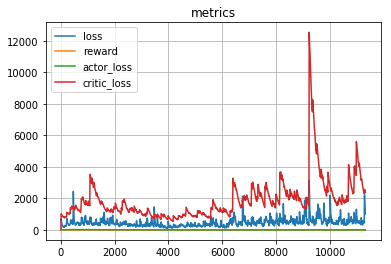

Random session examples.


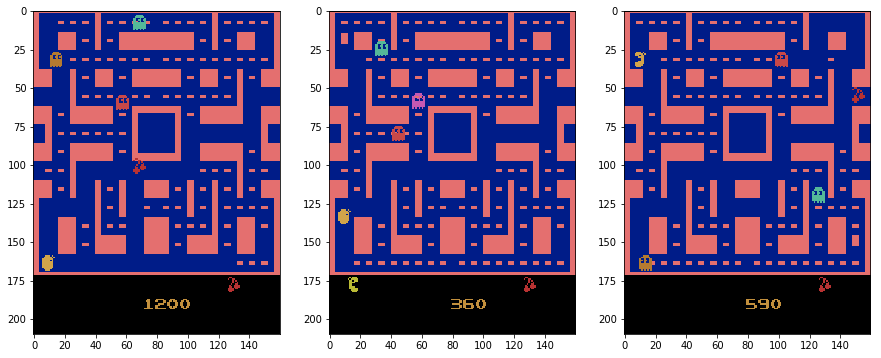

epoch 11310,loss 1250.16420 (A: 2.16872, C: 2303.25079), epsilon 0.05001, reward 0.84170
epoch 11320,loss 848.74268 (A: 2.00733, C: 2223.07848), epsilon 0.05001, reward 0.84161
epoch 11330,loss 764.18740 (A: 1.91646, C: 2153.29382), epsilon 0.05001, reward 0.83371
epoch 11340,loss 720.44478 (A: 1.76422, C: 2112.74776), epsilon 0.05001, reward 0.82279
epoch 11350,loss 624.29382 (A: 2.06618, C: 2082.82790), epsilon 0.05001, reward 0.82950
epoch 11360,loss 774.78443 (A: 2.21590, C: 2020.30367), epsilon 0.05001, reward 0.83294
epoch 11370,loss 2006.63008 (A: 2.19729, C: 1973.94803), epsilon 0.05001, reward 0.83134
epoch 11380,loss 1423.12882 (A: 1.98655, C: 1896.99492), epsilon 0.05001, reward 0.82297
epoch 11390,loss 1361.88784 (A: 2.16608, C: 1832.96637), epsilon 0.05001, reward 0.82382
epoch 11400,loss 1432.46103 (A: 1.97261, C: 1837.13522), epsilon 0.05001, reward 0.81046
Learning curves:


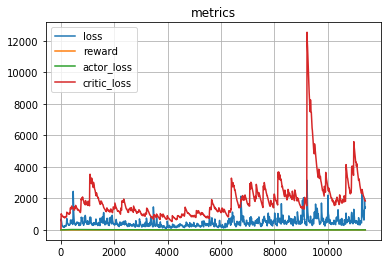

Random session examples.


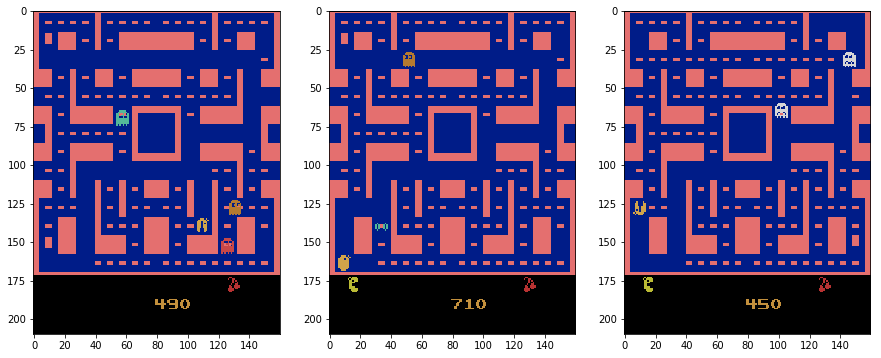

epoch 11410,loss 926.54291 (A: 2.49527, C: 1846.86085), epsilon 0.05000, reward 0.83146
epoch 11420,loss 766.24033 (A: 3.17511, C: 2182.72552), epsilon 0.05000, reward 0.84799


In [ ]:
n_epochs = 30000

for i in range(n_epochs):    
    #train
    pool.update(64)  
    loss = 0.95*loss + 0.05*train_step()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
    
        ##update learning curves
        actor_loss, critic_loss = eval_step()
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
        prev_actor_loss = 0.95*prev_actor_loss + 0.05*actor_loss
        prev_critic_loss = 0.95*prev_critic_loss + 0.05*critic_loss
        
        score_log["reward"][epoch_counter] = reward_per_tick
        score_log["loss"][epoch_counter] = loss
        score_log["actor_loss"][epoch_counter] = prev_actor_loss
        score_log["critic_loss"][epoch_counter] = prev_critic_loss
        

        print("epoch %i,loss %.5f (A: %.5f, C: %.5f), epsilon %.5f, reward %.5f"%(
            epoch_counter, loss, prev_actor_loss, prev_critic_loss, current_epsilon, reward_per_tick))
    
    ##record current learning progress and show learning curves
    if epoch_counter %100 ==0:
        print("Learning curves:")
        score_log.plot()

        print("Random session examples.")
        display_sessions()
    
    #run several sessions of game, record videos and save obtained results
    if epoch_counter %1000 ==0:
        rws = np.array(pool.evaluate(n_games=20,save_path="a2c_videos",record_video=True))
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_a2c_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        
    epoch_counter  +=1

    
# Time to drink some coffee!

## Record videos

In [68]:
rws = np.array(pool.evaluate(n_games=220,save_path="a2c1_videos",record_video=True))
print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
np.savez(open('rws4hist_a2c1_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)

[2017-05-25 01:54:21,595] Making new env: MsPacman-v0
[2017-05-25 01:54:21,846] Starting new video recorder writing to /home/vishimtsev/folder/a2c1_videos/openaigym.video.12.10942.video000000.mp4
[2017-05-25 01:54:24,697] Starting new video recorder writing to /home/vishimtsev/folder/a2c1_videos/openaigym.video.12.10942.video000001.mp4


Episode finished after 909 timesteps with reward=190.0
Episode finished after 490 timesteps with reward=180.0
Episode finished after 880 timesteps with reward=780.0
Episode finished after 706 timesteps with reward=380.0
Episode finished after 447 timesteps with reward=110.0
Episode finished after 465 timesteps with reward=110.0
Episode finished after 692 timesteps with reward=380.0


[2017-05-25 01:54:35,868] Starting new video recorder writing to /home/vishimtsev/folder/a2c1_videos/openaigym.video.12.10942.video000008.mp4


Episode finished after 435 timesteps with reward=60.0
Episode finished after 443 timesteps with reward=60.0
Episode finished after 506 timesteps with reward=60.0
Episode finished after 550 timesteps with reward=110.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 567 timesteps with reward=110.0
Episode finished after 782 timesteps with reward=780.0
Episode finished after 526 timesteps with reward=110.0
Episode finished after 581 timesteps with reward=120.0
Episode finished after 566 timesteps with reward=110.0
Episode finished after 710 timesteps with reward=180.0
Episode finished after 559 timesteps with reward=110.0
Episode finished after 705 timesteps with reward=380.0
Episode finished after 1003 timesteps with reward=180.0
Episode finished after 464 timesteps with reward=110.0
Episode finished after 831 timesteps with reward=780.0
Episode finished after 560 timesteps with reward=110.0
Episode finished after 465 timesteps with reward=110.0
Episode finis

[2017-05-25 01:55:06,064] Starting new video recorder writing to /home/vishimtsev/folder/a2c1_videos/openaigym.video.12.10942.video000027.mp4


Episode finished after 428 timesteps with reward=60.0
Episode finished after 948 timesteps with reward=180.0
Episode finished after 842 timesteps with reward=180.0
Episode finished after 733 timesteps with reward=380.0
Episode finished after 746 timesteps with reward=180.0
Episode finished after 592 timesteps with reward=230.0
Episode finished after 533 timesteps with reward=110.0
Episode finished after 452 timesteps with reward=110.0
Episode finished after 464 timesteps with reward=110.0
Episode finished after 519 timesteps with reward=60.0
Episode finished after 432 timesteps with reward=60.0
Episode finished after 535 timesteps with reward=110.0
Episode finished after 487 timesteps with reward=110.0
Episode finished after 430 timesteps with reward=60.0
Episode finished after 487 timesteps with reward=70.0
Episode finished after 566 timesteps with reward=110.0
Episode finished after 431 timesteps with reward=60.0
Episode finished after 1025 timesteps with reward=380.0
Episode finishe

[2017-05-25 01:56:03,496] Starting new video recorder writing to /home/vishimtsev/folder/a2c1_videos/openaigym.video.12.10942.video000064.mp4


Episode finished after 520 timesteps with reward=110.0
Episode finished after 768 timesteps with reward=380.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 539 timesteps with reward=140.0
Episode finished after 522 timesteps with reward=110.0
Episode finished after 1057 timesteps with reward=200.0
Episode finished after 768 timesteps with reward=780.0
Episode finished after 735 timesteps with reward=780.0
Episode finished after 599 timesteps with reward=380.0
Episode finished after 869 timesteps with reward=180.0
Episode finished after 529 timesteps with reward=110.0
Episode finished after 524 timesteps with reward=110.0
Episode finished after 520 timesteps with reward=110.0
Episode finished after 776 timesteps with reward=430.0
Episode finished after 423 timesteps with reward=60.0
Episode finished after 615 timesteps with reward=180.0
Episode finished after 809 timesteps with reward=380.0
Episode finished after 696 timesteps with reward=180.0
Episode fin

[2017-05-25 01:57:43,035] Starting new video recorder writing to /home/vishimtsev/folder/a2c1_videos/openaigym.video.12.10942.video000125.mp4


Episode finished after 535 timesteps with reward=110.0
Episode finished after 902 timesteps with reward=180.0
Episode finished after 973 timesteps with reward=400.0
Episode finished after 707 timesteps with reward=380.0
Episode finished after 646 timesteps with reward=180.0
Episode finished after 469 timesteps with reward=110.0
Episode finished after 477 timesteps with reward=110.0
Episode finished after 436 timesteps with reward=60.0
Episode finished after 570 timesteps with reward=110.0
Episode finished after 558 timesteps with reward=110.0
Episode finished after 692 timesteps with reward=380.0
Episode finished after 459 timesteps with reward=110.0
Episode finished after 522 timesteps with reward=60.0
Episode finished after 669 timesteps with reward=380.0
Episode finished after 539 timesteps with reward=110.0
Episode finished after 514 timesteps with reward=110.0
Episode finished after 569 timesteps with reward=110.0
Episode finished after 870 timesteps with reward=530.0
Episode fini

[2017-05-25 02:00:06,781] Starting new video recorder writing to /home/vishimtsev/folder/a2c1_videos/openaigym.video.12.10942.video000216.mp4


Episode finished after 670 timesteps with reward=380.0
Episode finished after 539 timesteps with reward=110.0
Episode finished after 433 timesteps with reward=60.0
Episode finished after 712 timesteps with reward=180.0


[2017-05-25 02:00:13,222] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/a2c1_videos')


Episode finished after 666 timesteps with reward=380.0
Mean 207.818181818, Var 38468.8760331


In [70]:
np.save(open('a2c_loss_log.pcl', 'wb'), score_log['loss'])
np.save(open('a2c_actor_log.pcl', 'wb'), score_log['actor_loss'])
np.save(open('a2c_critic_log.pcl', 'wb'), score_log['critic_loss'])
np.save(open('a2c_rewards_log.pcl', 'wb'), score_log['reward'])

###### Patially used code: Aleksey Grinchuk (AlexGrinch), Mariya Popova (Mariewelt) ... and some hedgehog